In [201]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from tensorflow.keras.utils import plot_model

import sys
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour

import warnings
warnings.filterwarnings('ignore')

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
sys.path.append('/content/drive/MyDrive/DataSci207/notebooks/')
base_path = '/content/drive/MyDrive/DataSci207/'


# Load data

In [204]:
# Load split data config
data_w_split_info = pd.read_csv((base_path + "config/work_df_w_split_info.csv"))
data_w_split_info['y_class_encoded'] = data_w_split_info['y_species_encoded']

class_names = list(np.unique(data_w_split_info['class']))

# encode species labels
label_encoder = LabelEncoder()
data_w_split_info['y_species_encoded'] = label_encoder.fit_transform(data_w_split_info['primary_label'])      # numeric code per species
species_names = label_encoder.classes_
data_w_split_info.head()

,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split,y_class_encoded
0,1139490,0.0,1139490/CSA36385.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta,0,test,2
1,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,0,train,2
2,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,1,train,2
3,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,1,train,2
4,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,1,val,2


In [205]:
def decode_species_names(encoded_species_list):
  return label_encoder.inverse_transform(encoded_species_list)

In [206]:
print("class_names length:", len(class_names) , "\nspecies_names length:" , len(species_names))

class_names length: 4 
species_names length: 206


In [207]:
## Load in spectrogram images
img_size = 64

if img_size == 32:
  graph_dict=np.load(base_path + 'data/processed/debug_birdclef2025_melspec_5sec_32_32.npy',allow_pickle=True).item()
elif img_size == 64:
  graph_dict=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_64_64.npy',allow_pickle=True).item()
else:
  graph_dict=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True).item()

len(graph_dict.keys())


28564

In [208]:
#Distribution of Dataset across train, val, test
data_w_split_info['split'].value_counts()

,count
split,
train,17138
test,5713
val,5713


In [209]:
# separate the data splits from common file

train_species_class_df = data_w_split_info[data_w_split_info['split'] == 'train']
val_species_class_df = data_w_split_info[data_w_split_info['split'] == 'val']
test_species_class_df = data_w_split_info[data_w_split_info['split'] == 'test']
print("train_species_class_df shape=", train_species_class_df.shape)
print("val_species_class_df shape=", val_species_class_df.shape)
print("test_species_class_df shape=", val_species_class_df.shape)



train_species_class_df shape= (17138, 10)
val_species_class_df shape= (5713, 10)
test_species_class_df shape= (5713, 10)


# EDA

In [210]:
# Distribution of data across each Class
data_w_split_info['class'].value_counts()

,count
class,
Aves,27648
Amphibia,583
Mammalia,178
Insecta,155


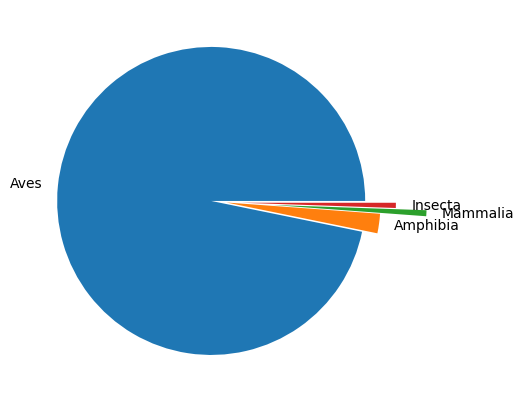

In [211]:
data = np.array(data_w_split_info['class'].value_counts().values)
labels = np.array(data_w_split_info['class'].value_counts().index)
explode = [0.1,0.0,0.3, 0.1]
plt.figure(figsize=(5, 5))
plt.pie(data, labels=labels, explode = explode)
plt.show()

We observe that data is highly imbalanced so we will need to address the unbalanced dataset.

In [212]:
# Distribution of Dataset across each Species
data_w_split_info['primary_label'].value_counts()

,count
primary_label,
grekis,990
compau,808
trokin,787
roahaw,709
banana,610
...,...
42113,2
21116,2
1139490,2


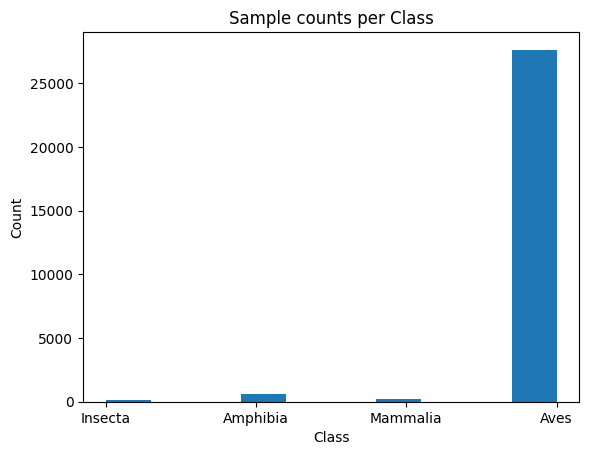

In [213]:
plt.hist(data_w_split_info['class'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Sample counts per Class")
plt.show()

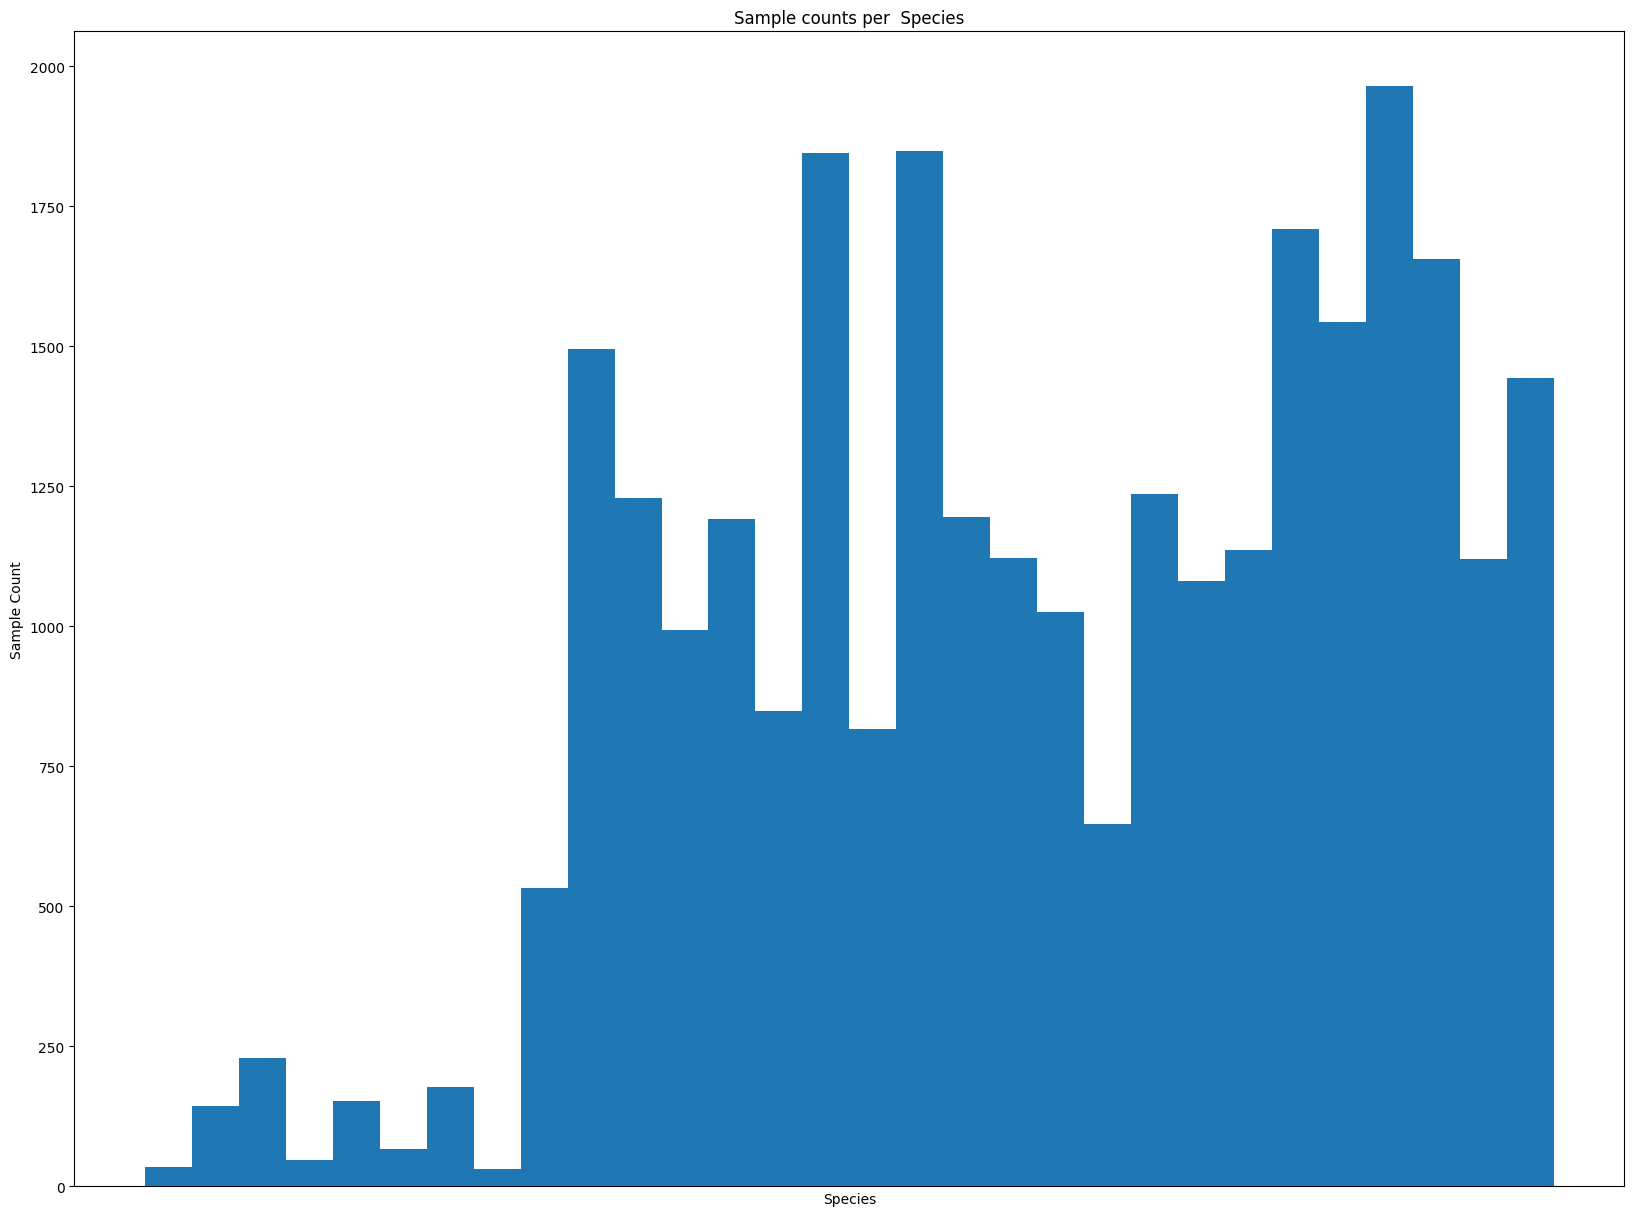

In [214]:

fig = plt.figure(figsize=(20, 15))
plt.hist(data_w_split_info['primary_label'], bins=30)
plt.xlabel('Species')
# Set the maximum number of major ticks on the x-axis to 4
#plt.xxaxis.set_major_locator(MaxNLocator(4))
#plt.locator_params(axis='x', nbins=10)
#skip_interval = 60
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Sample Count')
plt.title("Sample counts per  Species")
plt.show()

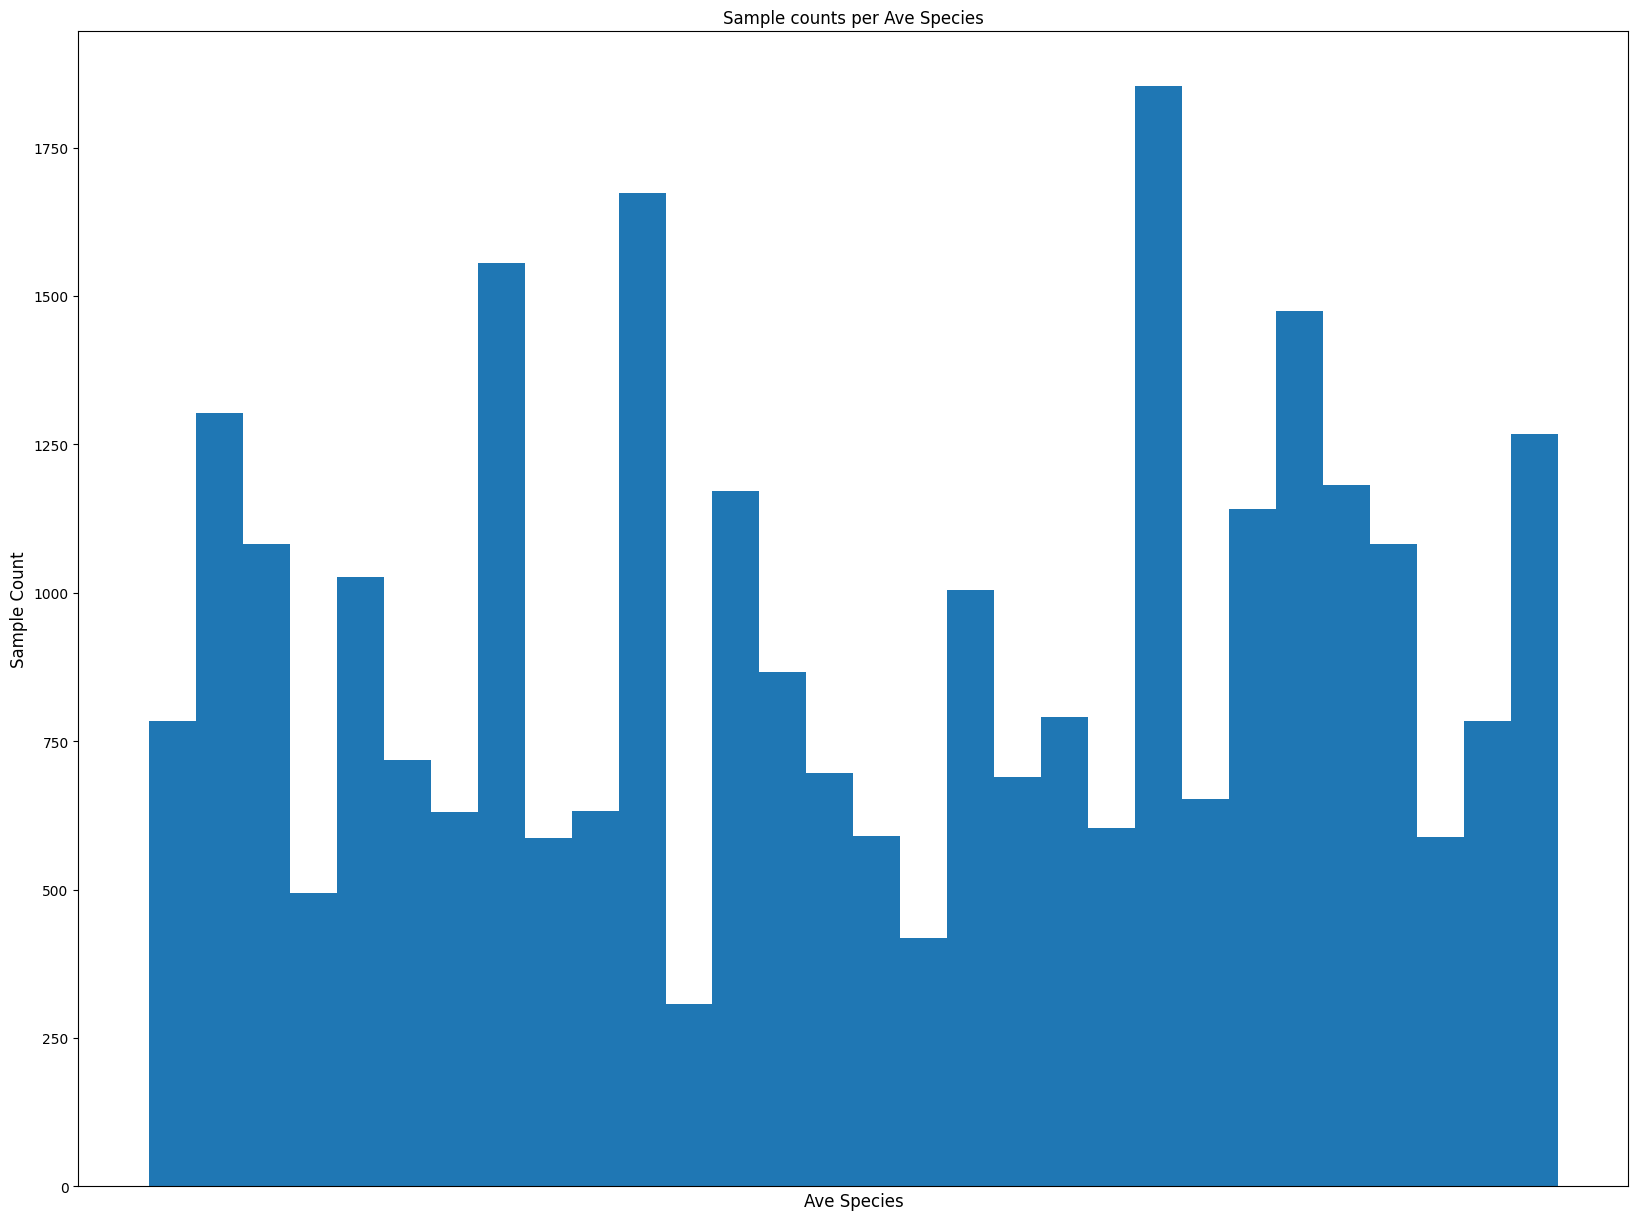

In [215]:
ave_samples = data_w_split_info[data_w_split_info['class']== 'Aves']
fig = plt.figure(figsize=(20, 15))
plt.hist(ave_samples['primary_label'], bins=30)
plt.xlabel('Ave Species', fontsize='large')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Sample Count', fontsize='large')
plt.title("Sample counts per Ave Species")
plt.show()

In [216]:
species_counts = data_w_split_info["primary_label"].value_counts()
print(f"{list(species_counts.index)[0]} Species has highest samples count :  ", max(species_counts) ,
      f"\n{list(species_counts.index)[-1]} Species has lowest samples count : ", min(species_counts))

top_species = list((species_counts[species_counts > 500]).index)
top_species_class = np.unique(list(data_w_split_info[data_w_split_info["primary_label"].isin(top_species)]["class"]))
print("top_species_class", top_species_class)

high_count_species = list((species_counts[species_counts < 500]).index)
low_count_species = list((species_counts[species_counts < 500]).index)


grekis Species has highest samples count :   990 
64862 Species has lowest samples count :  2
top_species_class ['Aves']


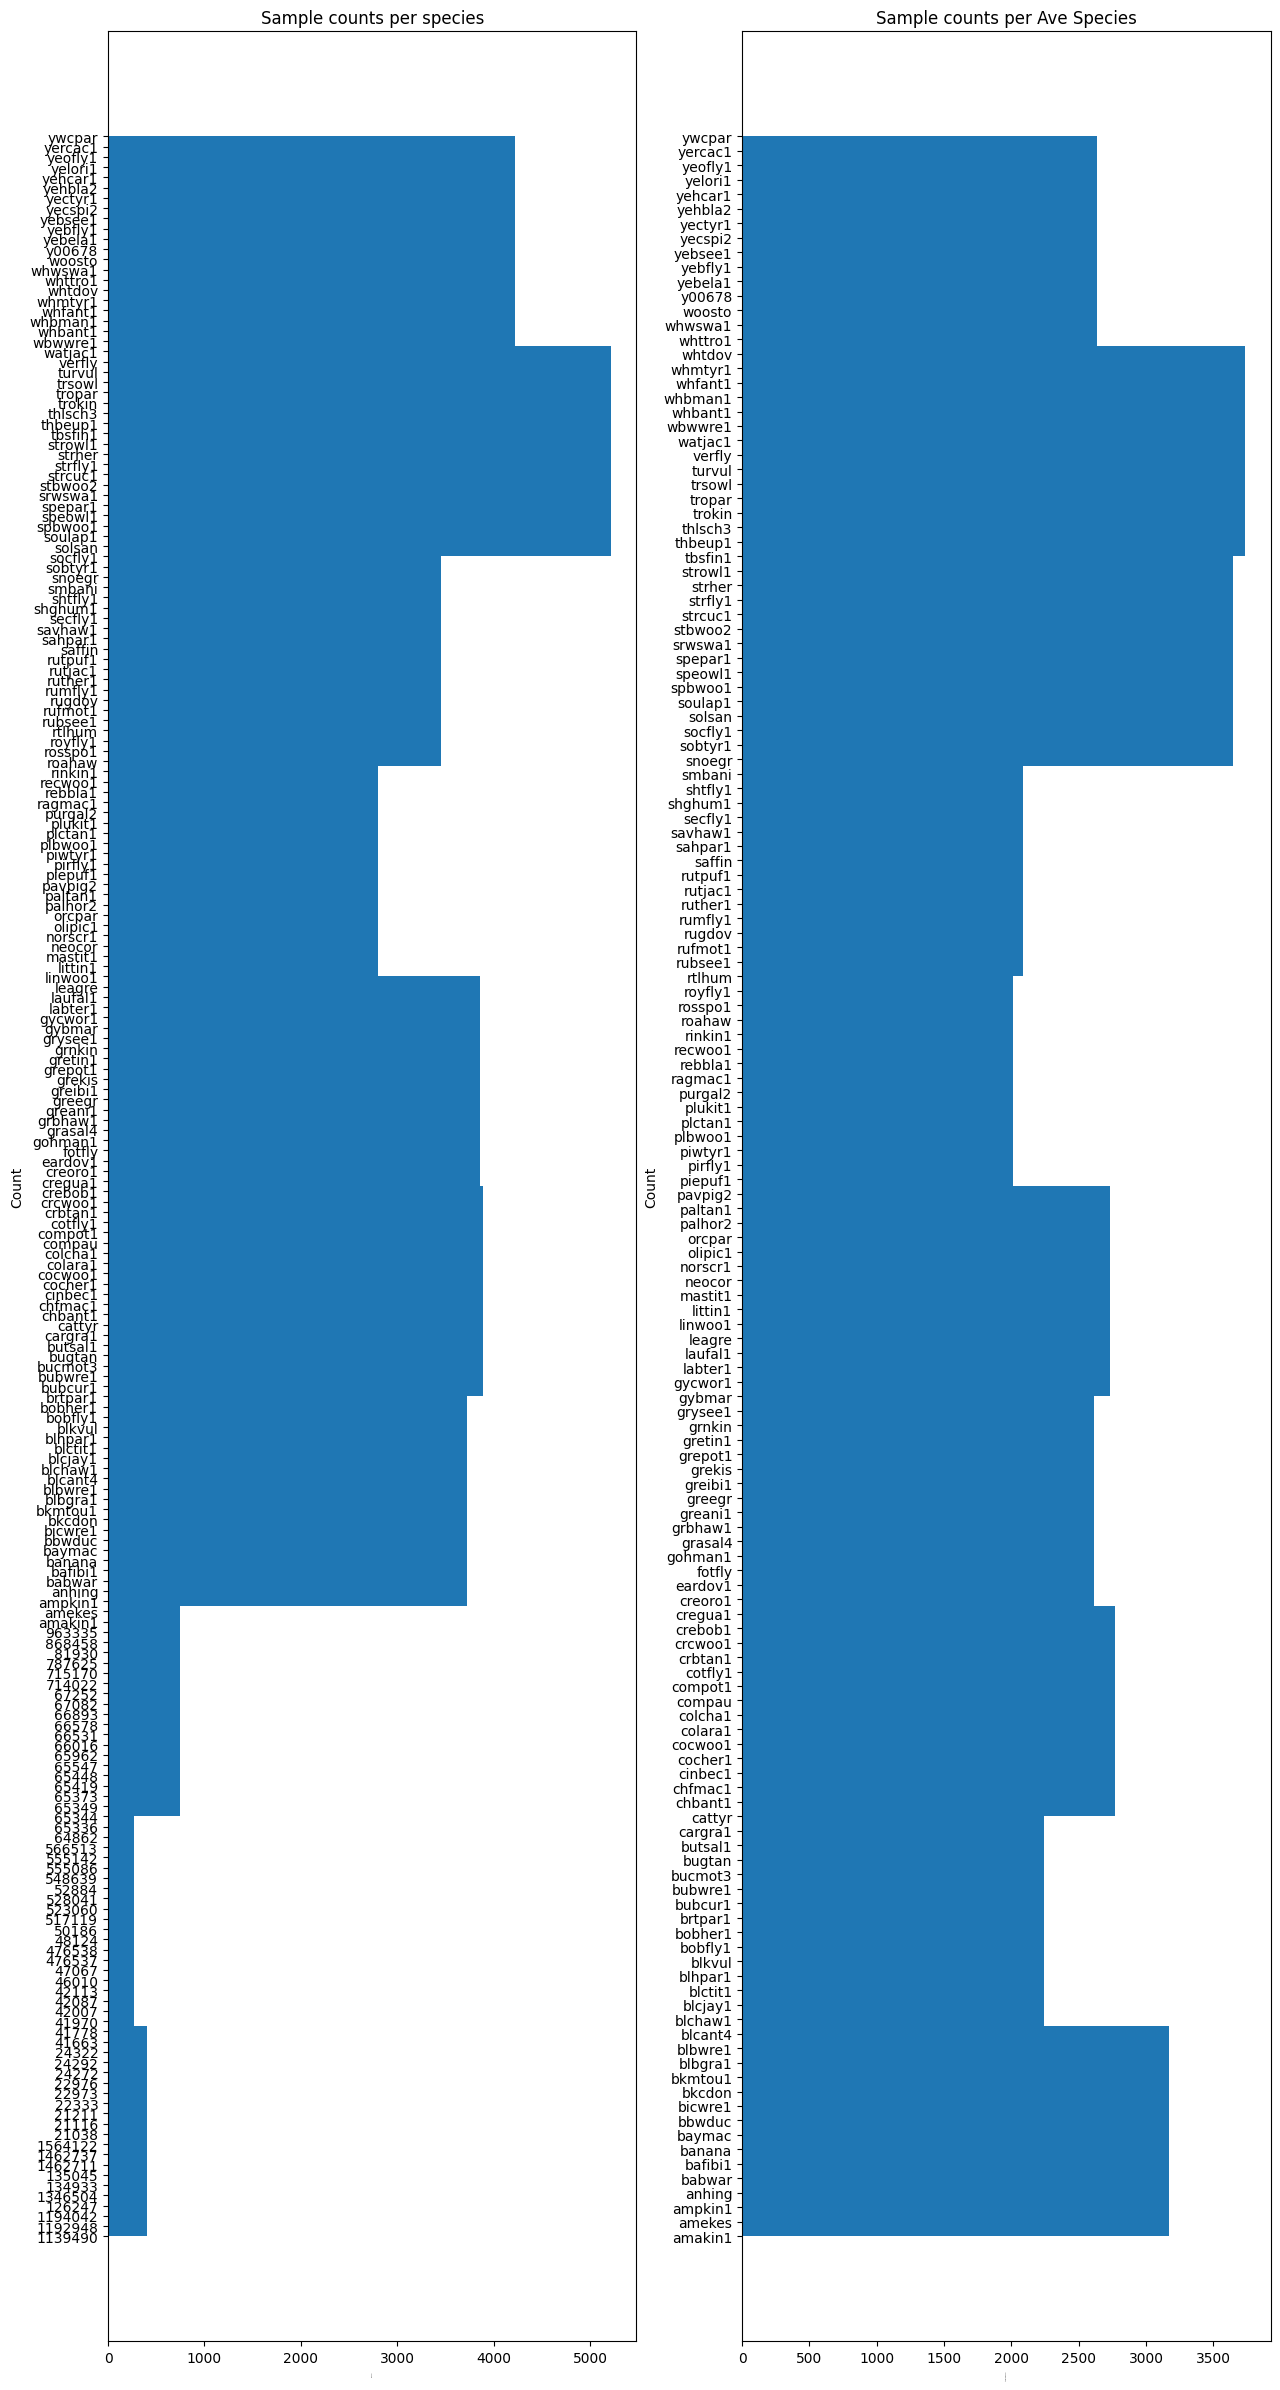

In [217]:

fig = plt.figure(figsize=(15,30))

ax = fig.add_subplot(1,2,1)
ax.hist(data_w_split_info['primary_label'], orientation='horizontal')
ax.set_xlabel('Species', fontsize=1, rotation=90)
ax.set_ylabel('Count')
ax.set_title("Sample counts per species")

ave_samples = data_w_split_info[data_w_split_info['class']== 'Aves']
ax=fig.add_subplot(1,2,2)
ax.hist(ave_samples['primary_label'], orientation='horizontal')
ax.set_xlabel('Aves Species', fontsize=1, rotation=90)
ax.set_ylabel('Count')
ax.set_title("Sample counts per Ave Species")


plt.show()


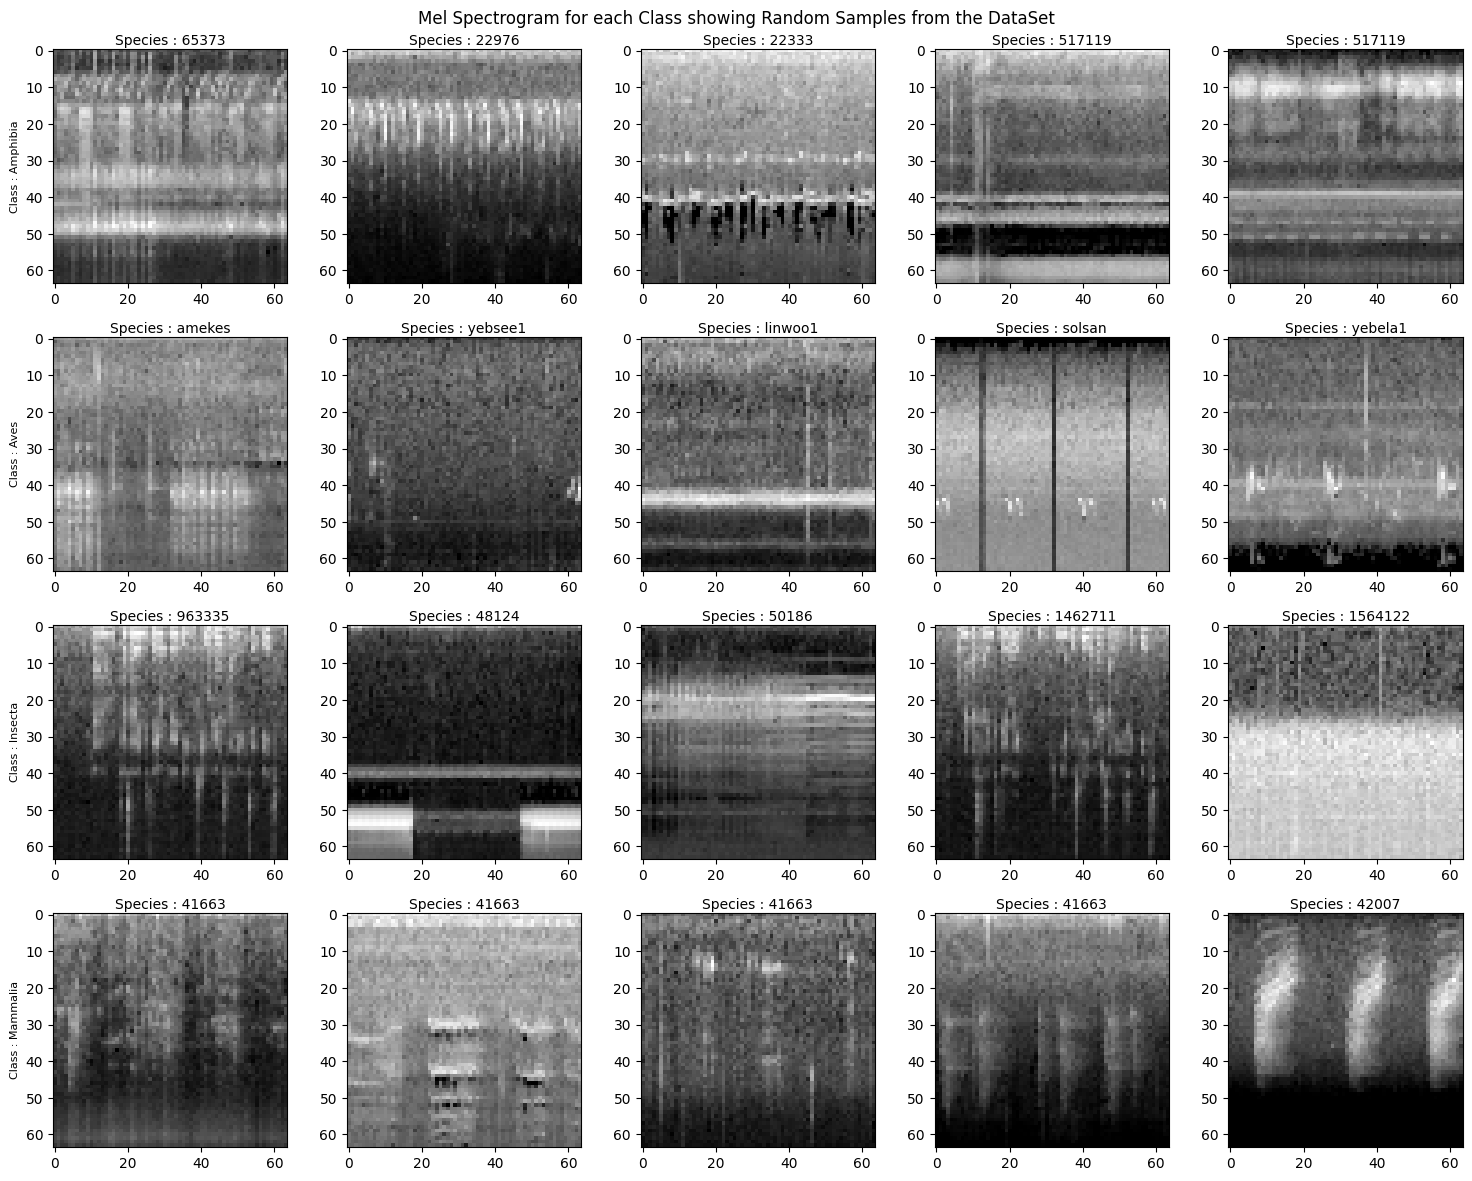

In [218]:
np.random.seed(1234)
class_list = np.unique(data_w_split_info['class'])

rows = len(class_list)
cols = 5
index = 0
fig, axes = plt.subplots(rows,cols, figsize=(cols*3,rows*3))
for row in np.arange(rows):
    df = data_w_split_info[data_w_split_info['class'] == class_list[row]]
    random_samples = random.sample(sorted(np.array(df[df['primary_label'].isin(high_count_species)]['samplename'])), 5)
    for col in np.arange(cols):
        ax = axes[row,col]
        ax.imshow(graph_dict[random_samples[col]], cmap='gray')
        species_name = data_w_split_info[data_w_split_info['samplename'] == random_samples[col]]['primary_label']
        if col == 0:
          class_title = "Class : " + class_list[row]
          ax.set_ylabel(class_title, fontsize=8)
        species_title = "Species : " + list(species_name)[0]
        ax.set_title(species_title, fontsize=10, va='center')
        index += 1
plt.suptitle("Mel Spectrogram for each Class showing Random Samples from the DataSet")
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.show()


Observations: We observe the images for the same class look quite different for different species.  Images across different classes appear to be similar. Difficult task to classifiy these images.

# Preparing data for ML

### Preparing Data for Aves Species Analysis

In [219]:
data_w_split_info[data_w_split_info['class'] == 'Aves']

,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split,y_class_encoded
916,amakin1,4.0,amakin1/XC113758.ogg,60,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,amakin1-XC113758,Aves,60,val,1
917,amakin1,2.5,amakin1/XC119209.ogg,60,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,amakin1-XC119209,Aves,60,val,1
918,amakin1,3.0,amakin1/XC120034.ogg,60,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,amakin1-XC120034,Aves,60,train,1
919,amakin1,3.0,amakin1/XC127702.ogg,60,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,amakin1-XC127702,Aves,60,train,1
920,amakin1,5.0,amakin1/XC128795.ogg,60,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,amakin1-XC128795,Aves,60,train,1
...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,0.0,ywcpar/iNat77392.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat77392,Aves,205,val,1
28560,ywcpar,0.0,ywcpar/iNat78624.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat78624,Aves,205,train,1
28561,ywcpar,0.0,ywcpar/iNat789234.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat789234,Aves,205,train,1
28562,ywcpar,0.0,ywcpar/iNat819873.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat819873,Aves,205,train,1


In [220]:
aves_data = data_w_split_info[data_w_split_info['class'] == 'Aves']
# encode aves species labels
label_encoder = LabelEncoder()
aves_data['y_aves_encoded'] = label_encoder.fit_transform(aves_data['primary_label'])      # numeric code per aves species
aves_species_names = label_encoder.classes_

print("num of Ave species: ", len(aves_species_names))
aves_species_names

num of Ave species:  146


array(['amakin1', 'amekes', 'ampkin1', 'anhing', 'babwar', 'bafibi1',
       'banana', 'baymac', 'bbwduc', 'bicwre1', 'bkcdon', 'bkmtou1',
       'blbgra1', 'blbwre1', 'blcant4', 'blchaw1', 'blcjay1', 'blctit1',
       'blhpar1', 'blkvul', 'bobfly1', 'bobher1', 'brtpar1', 'bubcur1',
       'bubwre1', 'bucmot3', 'bugtan', 'butsal1', 'cargra1', 'cattyr',
       'chbant1', 'chfmac1', 'cinbec1', 'cocher1', 'cocwoo1', 'colara1',
       'colcha1', 'compau', 'compot1', 'cotfly1', 'crbtan1', 'crcwoo1',
       'crebob1', 'cregua1', 'creoro1', 'eardov1', 'fotfly', 'gohman1',
       'grasal4', 'grbhaw1', 'greani1', 'greegr', 'greibi1', 'grekis',
       'grepot1', 'gretin1', 'grnkin', 'grysee1', 'gybmar', 'gycwor1',
       'labter1', 'laufal1', 'leagre', 'linwoo1', 'littin1', 'mastit1',
       'neocor', 'norscr1', 'olipic1', 'orcpar', 'palhor2', 'paltan1',
       'pavpig2', 'piepuf1', 'pirfly1', 'piwtyr1', 'plbwoo1', 'plctan1',
       'plukit1', 'purgal2', 'ragmac1', 'rebbla1', 'recwoo1', 'rinkin1

In [221]:
def one_hot_encode_y(encoded_y, num_classes):
  #One hot encode the y labels
  return to_categorical(encoded_y, num_classes)

X_aves_train, X_aves_val, X_aves_test  = [], [], []
y_aves_train, y_aves_val, y_aves_test  = [], [], []

# One hot encode y labels
y_aves_categorical = to_categorical(aves_data['y_aves_encoded'],
                               num_classes = len(aves_species_names))

counter = 0
while counter <  aves_data.shape[0]:
      sample = aves_data.iloc[counter]
      img = graph_dict.get(sample['samplename'])
      #Add 1 color channel to grayscale image so we can use with CNN
      img = img.reshape(img.shape + (1,))
      if sample['split'] == 'train':
        X_aves_train.append(img)
        y_aves_train.append(sample['y_aves_encoded'])
      elif sample['split'] == 'val':
        X_aves_val.append(img)
        y_aves_val.append(sample['y_aves_encoded'])
      else :
        X_aves_test.append(img)
        y_aves_test.append(sample['y_aves_encoded'])
      counter += 1
X_aves_train = np.array(X_aves_train)
X_aves_val = np.array(X_aves_val)
X_aves_test = np.array(X_aves_test)

#One hot encode the y labels
num_aves_species = len(aves_species_names)
print("num_species = ", num_aves_species )

y_aves_train = one_hot_encode_y(np.array(y_aves_train),num_aves_species )
y_aves_val = one_hot_encode_y(np.array(y_aves_val),num_aves_species )
y_aves_test = one_hot_encode_y(np.array(y_aves_test),num_aves_species )



#Set Random Seed
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
rng = np.random.default_rng(seed=1234)
shuffled_indices_train = rng.permutation(range(X_aves_train.shape[0]))
shuffled_indices_val = rng.permutation(range(X_aves_val.shape[0]))
shuffled_indices_test = rng.permutation(range(X_aves_test.shape[0]))

# shuffle data #
##################
X_aves_train = X_aves_train[shuffled_indices_train]
y_aves_train = y_aves_train[shuffled_indices_train]


X_aves_val = X_aves_val[shuffled_indices_val]
y_aves_val = y_aves_val[shuffled_indices_val]

X_aves_test = X_aves_test[shuffled_indices_test]
y_aves_test = y_aves_test[shuffled_indices_test]



print(f'X_aves_train shape: {X_aves_train.shape}')
print(f'y_aves_train shape: {y_aves_train.shape}')


print(f'X_aves_val shape: {X_aves_val.shape}')
print(f'y_aves_val shape: {y_aves_val.shape}')


print(f'X_aves_test shape: {X_aves_test.shape}')
print(f'y_aves_test shape: {y_aves_test.shape}')


num_species =  146
X_aves_train shape: (16588, 64, 64, 1)
y_aves_train shape: (16588, 146)
X_aves_val shape: (5530, 64, 64, 1)
y_aves_val shape: (5530, 146)
X_aves_test shape: (5530, 64, 64, 1)
y_aves_test shape: (5530, 146)


In [222]:
# Check if TensorFlow sees a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected. Training will use CPU.")

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Baseline Predictions

In [223]:
#Baseline Aves Species Prediction

#Identify species with most audio samples in training dataset
y_aves_train_encoded = [np.argmax(sample) for sample in y_aves_train ]
aves_species_list_encoded, aves_species_count = list(np.unique(y_aves_train_encoded, return_counts=True))
majority_species_encoded =  aves_species_list_encoded[np.argmax(aves_species_count)]
majority_species = aves_species_names[majority_species_encoded]

minority_species_encoded = aves_species_list_encoded[np.argmin(aves_species_count)]
minority_species = aves_species_names[minority_species_encoded]

print(f"{majority_species} Species  has highest samples count :  ", int(np.max(aves_species_count)))
print(f"{minority_species} Species  has lowest samples count :  ", int(np.min(aves_species_count)))

## Create a baseline model for Aves species classification
y_baseline = [ int(x) for x in (y_aves_train_encoded == majority_species_encoded)]

## Building baseline
num_majority_species = np.max(aves_species_count)
print(f"Number of samples with {majority_species} species : {num_majority_species}")

num_non_majority_species = np.sum(aves_species_count) - num_majority_species
print(f"Number of samples with non-{majority_species} species: {num_non_majority_species}")

majority_label = 1 if num_majority_species > num_non_majority_species else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(len(y_baseline), majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    """
    Calculates the log loss between true labels and predicted probabilities.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(len(y_baseline))*(majority_label + 0.1 )

train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


grekis Species  has highest samples count :   597
plctan1 Species  has lowest samples count :   2
Number of samples with grekis species : 597
Number of samples with non-grekis species: 15991
Majority label: 0
Accuracy of majority label classifier: 0.9640
Log Loss on training data: 0.1844


We observe that baseline model has very high accuracy due to unbalanced data.

# Modeling

## Common methods

In [224]:
#Calculate class weights due to class imbalance
#Species class weights
y_aves_train_encoded = [np.argmax(sample) for sample in y_aves_train ]
aves_species_encoded = np.array(np.unique(y_aves_train_encoded))
aves_species_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=np.sort(aves_species_encoded),
                                        y=y_aves_train_encoded)
# Convert to a dictionary for Keras/TensorFlow
aves_species_weights_dict = dict(zip(aves_species_encoded,
                              aves_species_weights_list))



print("aves_species_weights_dict length = " , len(aves_species_weights_dict))
print(aves_species_weights_dict)

aves_species_weights_dict length =  146
{np.int64(0): np.float64(2.0657534246575344), np.int64(1): np.float64(0.4526551328930852), np.int64(2): np.float64(6.683319903303787), np.int64(3): np.float64(1.893607305936073), np.int64(4): np.float64(1.1030722170501397), np.int64(5): np.float64(6.683319903303787), np.int64(6): np.float64(0.3164803296829091), np.int64(7): np.float64(1.2086855144272808), np.int64(8): np.float64(0.46185544047221294), np.int64(9): np.float64(1.9932708483537611), np.int64(10): np.float64(1.1138866505506313), np.int64(11): np.float64(0.5948504625977192), np.int64(12): np.float64(0.48762419895349524), np.int64(13): np.float64(1.5563895665227998), np.int64(14): np.float64(1.7752568493150684), np.int64(15): np.float64(3.442922374429224), np.int64(16): np.float64(1.8625645632158097), np.int64(17): np.float64(7.574429223744292), np.int64(18): np.float64(0.8001157630715802), np.int64(19): np.float64(2.70515329419439), np.int64(20): np.float64(0.3618357909431987), np.int64

In [225]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  """

  """
  # plot loss curves
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 3, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=10)
  ax.set_title("Model Loss ")

  ax = fig.add_subplot(1, 3, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=10)
  ax.set_title("Model Accuracy")
  ax.set_ylim(0,1)

  ax = fig.add_subplot(1, 3, 3)
  ax.plot(x_arr, hist['f1_score'], '-o', label='Train F1 score.')
  ax.plot(x_arr, hist['val_f1_score'], '--<', label='Val F1 Score.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('F1 score', size=10)
  ax.set_title("Model F1 Score ")
  ax.set_ylim(0,1)
  plt.show()

  # evaluate the accuracy of model_tf on train and val datasets
  train_acc = hist['accuracy'][-1]
  val_acc = hist['val_accuracy'][-1]
  print('final train acc: %.3f' %train_acc)
  print('final val acc:   %.3f' %val_acc)
  if int(train_acc ) == 0:
    print("\nUnable to calculate percent diff as Train accuracy is zero")
  else:
    percent_diff = 100*(train_acc - val_acc)/train_acc
    print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))


In [226]:
def plot_confusion_matrix(trained_model, train_data, label_data):
  """ Plot confusion matrix
  """
  class_labels = aves_species_names
  y_hat = trained_model.predict(train_data, verbose=0)

  y_actual = [int(np.argmax(label)) for label in label_data]
  predicted_labels = [int(np.argmax(label)) for label in y_hat]
  print("test_label length : ", len(y_actual))
  print("predicted_labels length : ", len(predicted_labels))
  conf_matrix =  confusion_matrix(y_actual, predicted_labels)
  print("confusion matrix shape=", conf_matrix.shape)

  # Plot normalized confusion matrix
  if  len(class_labels) > 10:
    print("number of labels > 10. number of labels = ", len(class_labels))
     #plot probability distributions
    fig1 = plt.figure(figsize=(12, 15))

    ax = fig1.add_subplot(1, 1, 1)
    ax.hist(y_hat, label="Species probability distribution")
    ax.legend(fontsize=10)
    ax.set_xlabel('Probability', size=10)
    ax.set_ylabel('Count', size=10)
    plt.show()
  else:
    disp = ConfusionMatrixDisplay.from_predictions(
            y_actual,
            predicted_labels,
            display_labels=class_labels,
            cmap=plt.cm.Blues,
            normalize='true',
        )
    disp.ax_.set_title("Normalized confusion matrix")
    plt.show()

  #print classification report
  print(classification_report(y_actual, predicted_labels, target_names=class_labels))



In [227]:
# define an instance of the early_stopping class
early_stopping_acc = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [228]:
# define an instance of the early_stopping class
early_stopping_f1 = tf.keras.callbacks.EarlyStopping(
monitor='val_f1_score',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [229]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_acc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [230]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_f1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

### Data Augmentation functions

To address the highly unbalanced class labels, we will attempt augmentation using Resampling and Undersampling to balance the classes.

In [231]:
def add_smote_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #SMOTE expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = SMOTE().fit_resample(train_data, train_label)

        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [232]:
def add_adasyn_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #ADASYN expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = ADASYN().fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))


        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [233]:
def create_undersampled_data(train_data, train_label, undersampl_type=1):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #undersample expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        # define the undersampling method
        #undersample = CondensedNearestNeighbour(n_neighbors=1)
        if undersampl_type == 1:
            undersample = NearMiss( sampling_strategy="majority", version=3, n_neighbors_ver3=2)
        elif undersampl_type == 2:
            undersample = CondensedNearestNeighbour(sampling_strategy="majority",  n_neighbors=2)

        # transform the dataset
        X_undersampled, y_undersampled = undersample.fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))

        print("After augmentation: X shape:", X_undersampled.shape)
        print("After augmentation: y shape:", y_undersampled.shape)

        #Rebuild our 4D data array
        X_undersampled = X_undersampled.reshape(X_undersampled.shape[0],
                                                original_shape[1],
                                                original_shape[2],
                                                original_shape[3])
        print("Reshaped X_undersampled : ",X_undersampled.shape )

        #Shuffle data
        rng = np.random.default_rng(seed=1234)
        shuffled_indices = rng.permutation(range(X_undersampled.shape[0]))
        X_undersampled = X_undersampled[shuffled_indices]
        y_undersampled = y_undersampled[shuffled_indices]
        print("After shuffling: X shape:", X_undersampled.shape)
        print("After shuffling: y shape:", y_undersampled.shape)


        return X_undersampled, y_undersampled

#### Spectrogram Augmentation

In [234]:
def time_masking_batch(spectrograms, max_mask_size=30):
    def mask_one(spec):
        time_steps = tf.shape(spec)[0]
        mask_size = tf.random.uniform([], 0, max_mask_size + 1, dtype=tf.int32)
        start = tf.random.uniform([], 0, time_steps - mask_size + 1, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((start, spec.shape[1]), dtype=tf.float32),
            tf.zeros((mask_size, spec.shape[1]), dtype=tf.float32),
            tf.ones((time_steps - start - mask_size, spec.shape[1]), dtype=tf.float32)
        ], axis=0)
        return spec * mask

    return tf.map_fn(mask_one, spectrograms)
def frequency_masking_batch(spectrograms, max_mask_size=20):
    def mask_one(spec):
        freq_bins = tf.shape(spec)[1]
        mask_size = tf.random.uniform([], 0, max_mask_size + 1, dtype=tf.int32)
        start = tf.random.uniform([], 0, freq_bins - mask_size + 1, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((spec.shape[0], start), dtype=tf.float32),
            tf.zeros((spec.shape[0], mask_size), dtype=tf.float32),
            tf.ones((spec.shape[0], freq_bins - start - mask_size), dtype=tf.float32)
        ], axis=1)
        return spec * mask

    return tf.map_fn(mask_one, spectrograms)
def time_shift_batch(spectrograms, max_shift=20):
    def shift_one(spec):
        shift = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
        return tf.roll(spec, shift=shift, axis=0)

    return tf.map_fn(shift_one, spectrograms)
def amplitude_scaling_batch(spectrograms, scale_range=(0.7, 1.3)):
    def scale_one(spec):
        scale = tf.random.uniform([], scale_range[0], scale_range[1])
        return spec * scale

    return tf.map_fn(scale_one, spectrograms)

def apply_batched_augmentations(spectrograms):
    spectrograms = time_masking_batch(spectrograms)
    if np.random.rand() > 0.5:
      spectrograms = frequency_masking_batch(spectrograms)
    if np.random.rand() < 0.5:
     spectrograms = time_shift_batch(spectrograms)
    if np.random.rand() > 0.5:
      spectrograms = amplitude_scaling_batch(spectrograms)

    return spectrograms

In [235]:
def add_spectrogram_augmentation(spectrograms_4d, label_data):
  """
  """
  #1 Reshape data to remove color channel
  spectrograms_2d =  spectrograms_4d.reshape(spectrograms_4d.shape[0],
                                             spectrograms_4d.shape[1],
                                             spectrograms_4d.shape[2])
  print("Reshaped spectrogram shape : ", spectrograms_2d.shape)

  #2 Convert spectrogram to tensor
  spect_tensor = tf.convert_to_tensor(spectrograms_2d)
  spect_augm = ( apply_batched_augmentations(spect_tensor))
  print("Augmented spectrograms shape: ", spect_augm.shape)

  #3 Convert tensor back to numpy array and reshape with color channel
  spect_augm = spect_augm.numpy()
  spect_augm = spect_augm.reshape(spect_augm.shape + (1,) )
  print("Reshaped Augmented spectrograms shape: ", spect_augm.shape)

  #4 # concatenate original X and augmented X_aug data
  X_spec_augm = tf.concat([spectrograms_4d, spect_augm], axis=0)

  # concatenate y_train (note the label is preserved)
  y_augm = label_data
  y_spec_augm = tf.concat([label_data, y_augm],axis=0)
  print("After augmentation: X shape:", X_spec_augm.shape)
  print("After augmentation: y shape:", y_spec_augm.shape)

  #Convert to numpy
  X_spec_augm = X_spec_augm.numpy()
  y_spec_augm = y_spec_augm.numpy()

  #Add Shuffling
  rng = np.random.default_rng(seed=1234)
  shuffled_indices = rng.permutation(range(X_spec_augm.shape[0]))
  X_spec_augm = X_spec_augm[shuffled_indices]
  y_spec_augm = y_spec_augm[shuffled_indices]
  print("After shuffling: X shape:", X_spec_augm.shape)
  print("After shuffling: y shape:", y_spec_augm.shape)


  return X_spec_augm, y_spec_augm

# Analysis

### Aves Models

In [236]:
def build_aves_model_1(img_size, output_size):
  """ Train model based on selected parameters and display results
  Using Model_2 which has 2 blocks of convolutional layer followed by MaxPool
  """
  kernel = 3
  l_r = 0.01
  optimizer = 'RMSProp'
  strides = (2,2)

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=(kernel,kernel),
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=(kernel,kernel),
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)

  flat_1 = tf.keras.layers.Flatten()(maxpool_2)
  dropout_1 = tf.keras.layers.Dropout(rate=0.3)(flat_1)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model



In [237]:
def build_aves_model_2(img_size, output_size):
  """ Train model based on selected parameters and display results
  Using Model_2 which has 2 blocks of convolutional layer followed by MaxPool
  """
  kernel = (4,4)
  l_r = 0.01
  optimizer = 'RMSProp'
  strides = (2,2)

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)

  # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(normal_3)

  flat_1 = tf.keras.layers.Flatten()(maxpool_3)
  dense_1 = tf.keras.layers.Dense(128)(flat_1)
  dropout_1 = tf.keras.layers.Dropout(rate=0.4)(dense_1)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [238]:
def build_aves_model_3(img_size, output_size):
  """ Train model based on selected parameters and display results
  3 blocks of convolutional layer followed by 3 Dense Layers
  """
  kernel = (4,4)
  l_r = 0.01
  optimizer = 'Adam'
  strides = (2,2)
  maxpool = (2,2)
  dropout = 0.2
  dropout_dense = 0.3

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D(maxpool)(normal_1)
 # dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D(maxpool)(normal_2)
 # dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

  # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=kernel,
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(maxpool_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D(maxpool)(normal_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  flat_1 = tf.keras.layers.GlobalAveragePooling2D()(dropout_3)
  dense_1 = tf.keras.layers.Dense(128)(flat_1)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_1)
  dense_2 = tf.keras.layers.Dense(128)(dropout_4)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_2)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_5)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

#### Aves_model_1

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │       299,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,418 (1.43 MB)

 Trainable params: 374,034 (1.43 MB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0249 - f1_score: 0.0154 - loss: 7.3639 - val_accuracy: 0.0156 - val_f1_score: 0.0045 - val_loss: 6.9792
Epoch 2/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0943 - f1_score: 0.0541 - loss: 4.5776 - val_accuracy: 0.0391 - val_f1_score: 0.0134 - val_loss: 5.4670
Epoch 3/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1301 - f1_score: 0.0830 - loss: 4.2967 - val_accuracy: 0.0794 - val_f1_score: 0.0324 - val_loss: 5.4654
Epoch 4/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1530 - f1_score: 0.1055 - loss: 4.1269 - val_accuracy: 0.0599 - val_f1_score: 0.0363 - val_loss: 5.8791
Epoch 5/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1659 - f1_score: 0.1190 - loss: 4.0026 - val_accuracy: 0.0595 - val_f1_score: 0.0404 - val_loss: 5.6375
Epoch 6/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1845 - f1_score: 0.1404 - loss: 3.8632 - val_accuracy: 0.0712 - val_f1_score:

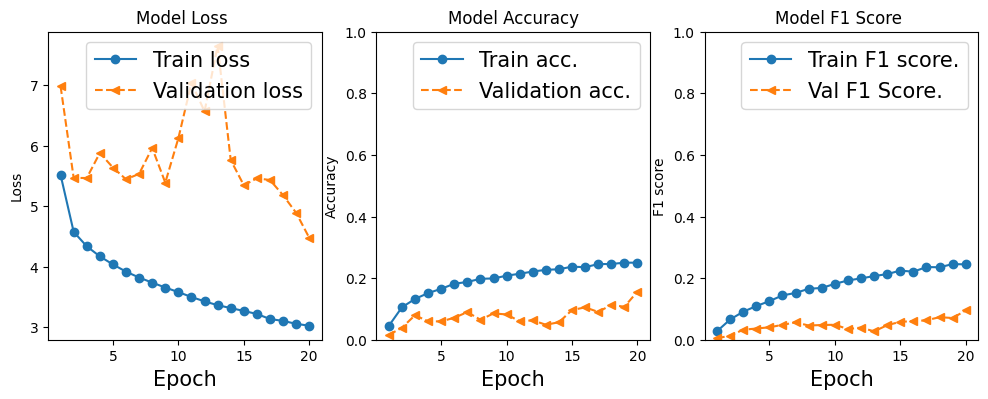

final train acc: 0.250
final val acc:   0.156

Unable to calculate percent diff as Train accuracy is zero
test_label length :  16588
predicted_labels length :  16588
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


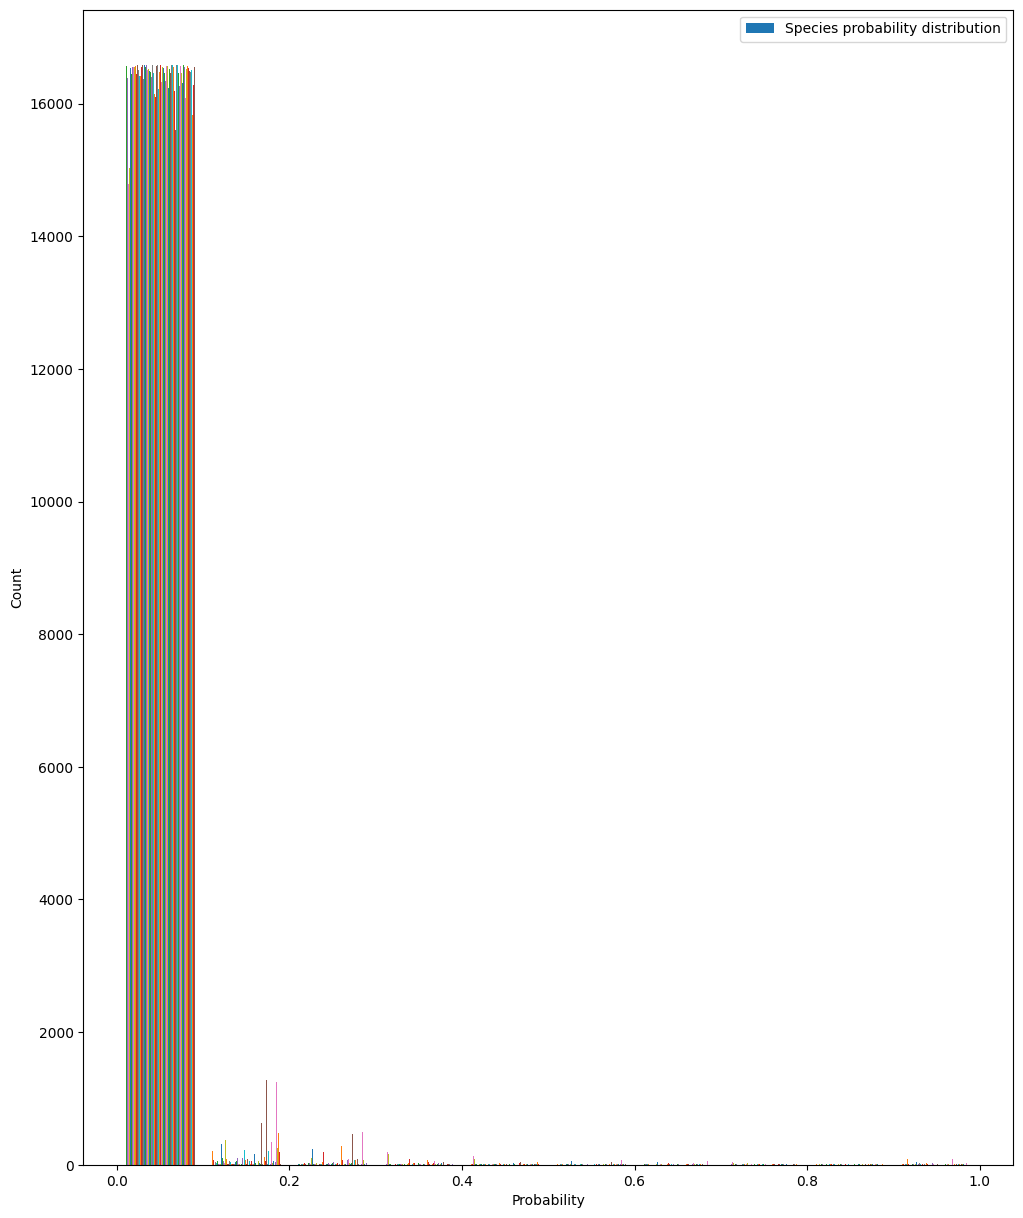

              precision    recall  f1-score   support

     amakin1       1.00      0.25      0.41        55
      amekes       0.45      0.34      0.39       251
     ampkin1       0.94      0.88      0.91        17
      anhing       0.39      0.53      0.45        60
      babwar       0.48      0.55      0.51       103
     bafibi1       1.00      0.24      0.38        17
      banana       0.25      0.77      0.38       359
      baymac       0.73      0.52      0.61        94
      bbwduc       0.18      0.58      0.28       246
     bicwre1       0.74      0.68      0.71        57
      bkcdon       0.84      0.25      0.39       102
     bkmtou1       0.91      0.74      0.82       191
     blbgra1       0.85      0.27      0.42       233
     blbwre1       0.56      0.47      0.51        73
     blcant4       0.90      0.41      0.56        64
     blchaw1       1.00      0.27      0.43        33
     blcjay1       0.82      0.30      0.43        61
     blctit1       1.00    

In [239]:


species_model_aves = build_aves_model_1(X_aves_train.shape[1],
                                              y_aves_train.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_train,
    y_aves_train,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=32,
    class_weight=aves_species_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_train,
                      y_aves_train)

#### Aves model 2

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │        18,834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,018 (3.08 MB)

 Trainable params: 807,378 (3.08 MB)

 Non-trainable params: 640 (2.50 KB)

None
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0273 - f1_score: 0.0100 - loss: 23.8294 - val_accuracy: 0.0083 - val_f1_score: 1.1301e-04 - val_loss: 58.8165
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1017 - f1_score: 0.0358 - loss: 4.2863 - val_accuracy: 0.0049 - val_f1_score: 6.8633e-05 - val_loss: 18.6140
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1313 - f1_score: 0.0528 - loss: 4.0863 - val_accuracy: 0.0045 - val_f1_score: 0.0012 - val_loss: 15.7482
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1580 - f1_score: 0.0690 - loss: 3.9288 - val_accuracy: 0.0615 - val_f1_score: 0.0210 - val_loss: 6.5899
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1703 - f1_score: 0.0770 - loss: 3.8531 - val_accuracy: 0.0465 - val_f1_score: 0.0248 - val_loss: 6.6925
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1869 - f1_score: 0.0872 - loss: 3.7655 - val_accuracy: 0.0722 - v

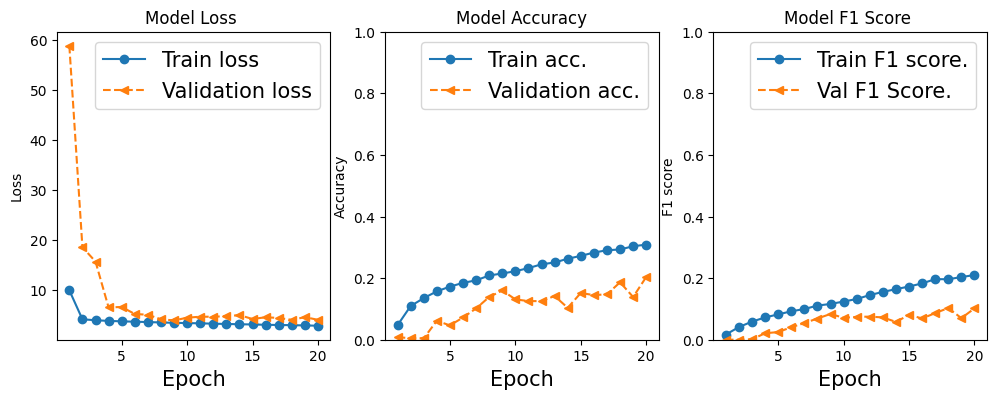

final train acc: 0.309
final val acc:   0.204

Unable to calculate percent diff as Train accuracy is zero
test_label length :  16588
predicted_labels length :  16588
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


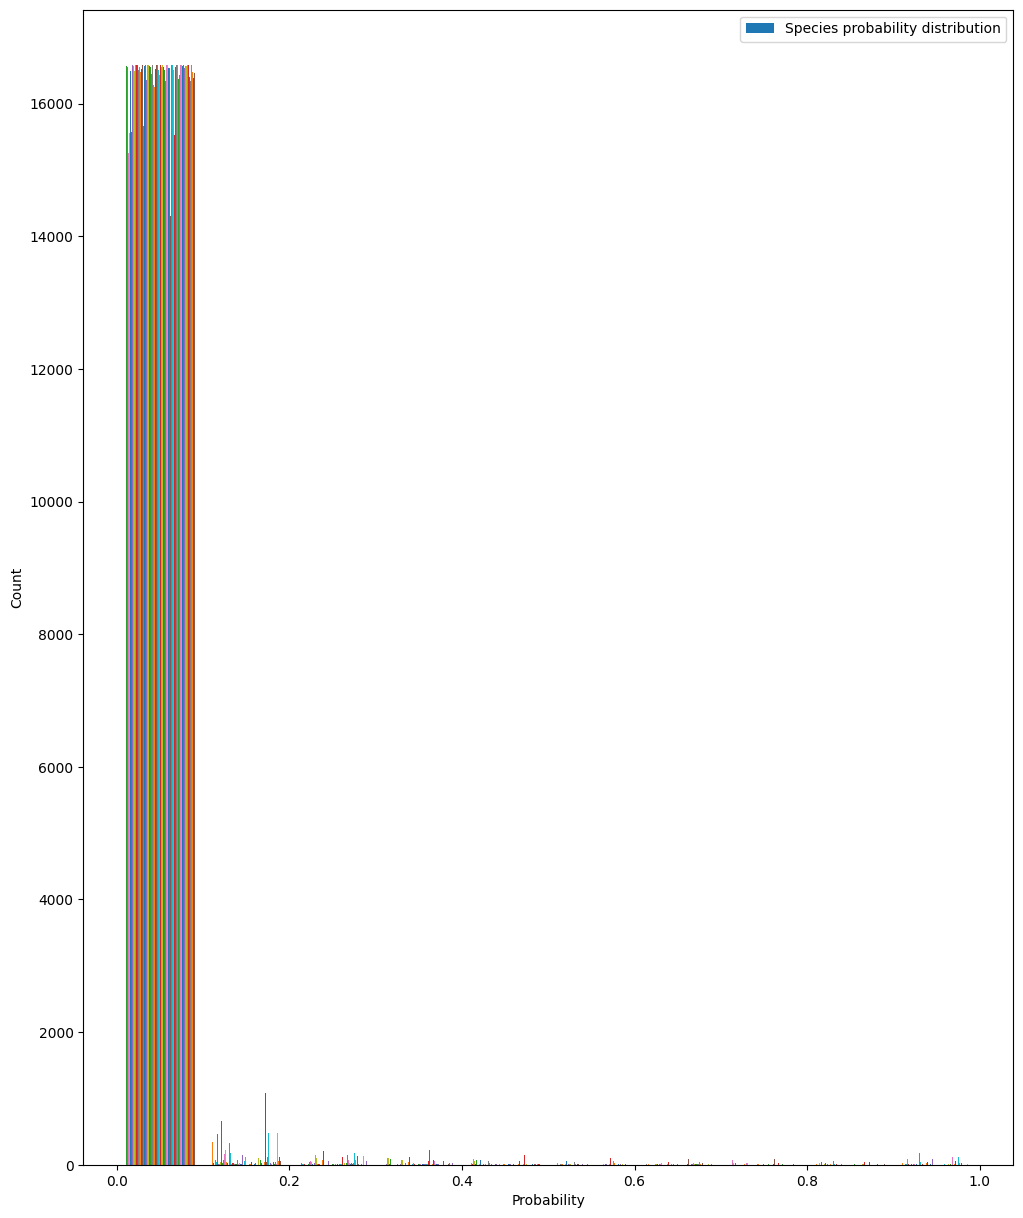

              precision    recall  f1-score   support

     amakin1       1.00      0.07      0.14        55
      amekes       0.42      0.61      0.49       251
     ampkin1       0.45      0.29      0.36        17
      anhing       0.41      0.20      0.27        60
      babwar       1.00      0.17      0.30       103
     bafibi1       1.00      0.12      0.21        17
      banana       0.34      0.77      0.47       359
      baymac       0.56      0.63      0.59        94
      bbwduc       0.29      0.64      0.40       246
     bicwre1       0.65      0.53      0.58        57
      bkcdon       0.74      0.45      0.56       102
     bkmtou1       0.93      0.76      0.84       191
     blbgra1       0.30      0.75      0.43       233
     blbwre1       0.85      0.40      0.54        73
     blcant4       1.00      0.06      0.12        64
     blchaw1       1.00      0.15      0.26        33
     blcjay1       1.00      0.10      0.18        61
     blctit1       0.00    

In [240]:
species_model_aves = build_aves_model_2(X_aves_train.shape[1],
                                              y_aves_train.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_train,
    y_aves_train,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    #class_weight=aves_species_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_train,
                      y_aves_train)

#### Aves model 3

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │        18,834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,866 (2.77 MB)

 Trainable params: 725,970 (2.77 MB)

 Non-trainable params: 896 (3.50 KB)

None
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.0316 - f1_score: 0.0108 - loss: 6.4634 - val_accuracy: 0.0387 - val_f1_score: 0.0043 - val_loss: 4.5036
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1032 - f1_score: 0.0327 - loss: 4.1430 - val_accuracy: 0.1224 - val_f1_score: 0.0380 - val_loss: 4.0483
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1580 - f1_score: 0.0608 - loss: 3.8387 - val_accuracy: 0.1025 - val_f1_score: 0.0365 - val_loss: 4.5699
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1878 - f1_score: 0.0768 - loss: 3.6710 - val_accuracy: 0.1964 - val_f1_score: 0.0888 - val_loss: 3.7784
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2009 - f1_score: 0.0864 - loss: 3.5590 - val_accuracy: 0.1834 - val_f1_score: 0.0794 - val_loss: 3.7638
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2202 - f1_score: 0.1004 - loss: 3.4784 - val_accuracy: 0.1875 - val_f1_score:

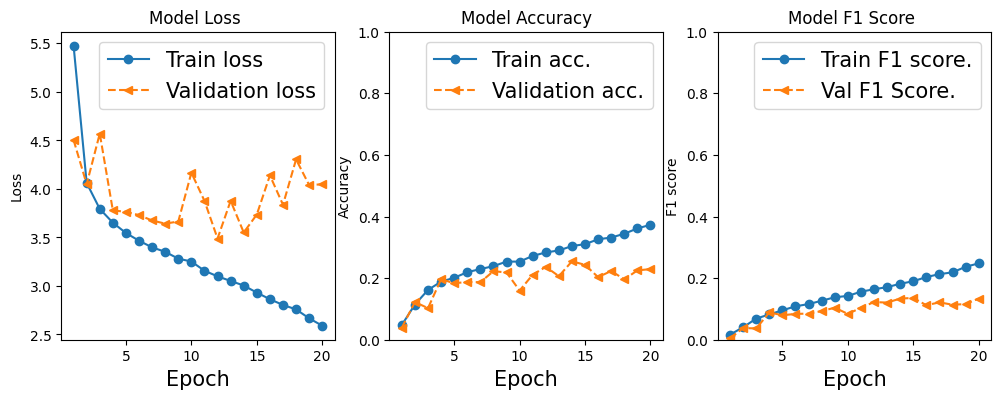

final train acc: 0.373
final val acc:   0.229

Unable to calculate percent diff as Train accuracy is zero
test_label length :  16588
predicted_labels length :  16588
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


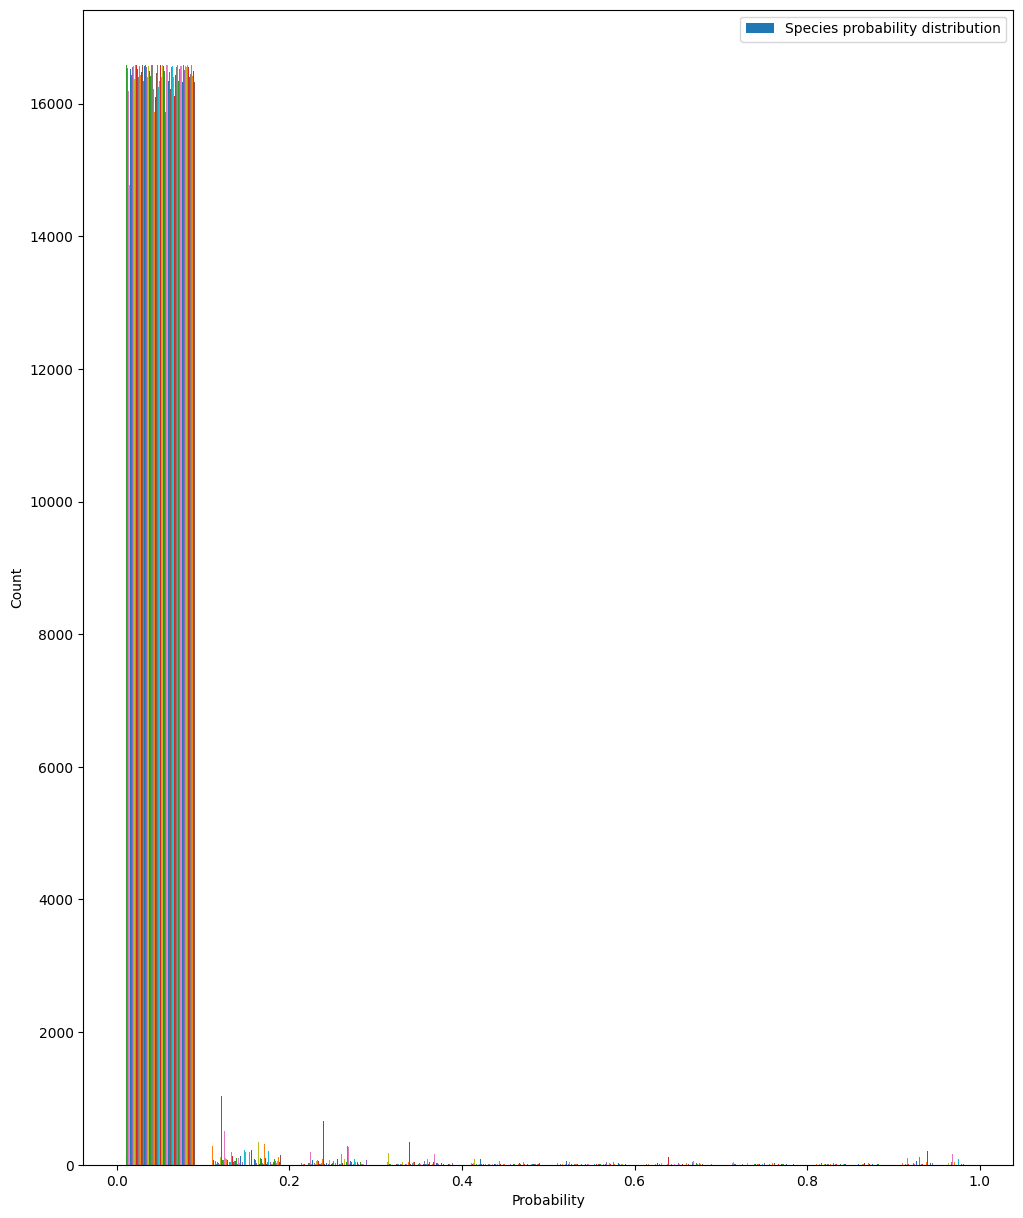

              precision    recall  f1-score   support

     amakin1       0.75      0.05      0.10        55
      amekes       0.39      0.49      0.43       251
     ampkin1       0.00      0.00      0.00        17
      anhing       0.16      0.12      0.13        60
      babwar       0.95      0.20      0.34       103
     bafibi1       0.00      0.00      0.00        17
      banana       0.76      0.58      0.65       359
      baymac       0.50      0.51      0.51        94
      bbwduc       0.18      0.65      0.28       246
     bicwre1       0.85      0.30      0.44        57
      bkcdon       0.82      0.23      0.35       102
     bkmtou1       0.89      0.75      0.81       191
     blbgra1       0.97      0.39      0.56       233
     blbwre1       1.00      0.26      0.41        73
     blcant4       0.75      0.23      0.36        64
     blchaw1       0.67      0.06      0.11        33
     blcjay1       0.78      0.11      0.20        61
     blctit1       0.00    

In [241]:
species_model_aves = build_aves_model_3(X_aves_train.shape[1],
                                              y_aves_train.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_train,
    y_aves_train,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    #class_weight=aves_species_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_train,
                      y_aves_train)

## Model Layers Tuning

|Model|conv blocks|dense layers|conv_dropout|dense_dropouut|batch|dense_depth|epochs|learning_rate|macro_f1|accuracy avg|yectyr1 recall|
|-|-|-|-|-|-|-|-|-|-|-|-|
|Model 1|3||||64|(256,128)|20|0.01|0.23|0.33|0.03|
|Model 2|3|1||0.3|64|(128,128)|20|0.01|0.27|0.35|0.05|
|Model 3|3|3|0.2|0.3|64|(128,128,64)|20|0.01|0.27|0.39|0.13|


# Testing with DownSampling

UnderSampling with CNN

In [242]:
X_aves_cnn, y_aves_cnn = create_undersampled_data(X_aves_train, y_aves_train,undersampl_type=2)

Before augmentation: X shape: (16588, 64, 64, 1)
Before augmentation: y shape: (16588, 146)
Reshaped train data :  (16588, 4096)
After augmentation: X shape: (15993, 4096)
After augmentation: y shape: (15993, 146)
Reshaped X_undersampled :  (15993, 64, 64, 1)
After shuffling: X shape: (15993, 64, 64, 1)
After shuffling: y shape: (15993, 146)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │        18,834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,866 (2.77 MB)

 Trainable params: 725,970 (2.77 MB)

 Non-trainable params: 896 (3.50 KB)

None
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.0292 - f1_score: 0.0111 - loss: 6.3834 - val_accuracy: 0.0620 - val_f1_score: 0.0110 - val_loss: 4.4793
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1031 - f1_score: 0.0331 - loss: 4.1334 - val_accuracy: 0.0617 - val_f1_score: 0.0172 - val_loss: 4.6501
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1485 - f1_score: 0.0571 - loss: 3.8418 - val_accuracy: 0.1143 - val_f1_score: 0.0423 - val_loss: 4.3397
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1795 - f1_score: 0.0801 - loss: 3.6797 - val_accuracy: 0.1689 - val_f1_score: 0.0739 - val_loss: 3.8779
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1965 - f1_score: 0.0881 - loss: 3.5948 - val_accuracy: 0.1767 - val_f1_score: 0.0677 - val_loss: 3.9994
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2071 - f1_score: 0.0964 - loss: 3.5131 - val_accuracy: 0.1866 - val_f1_score:

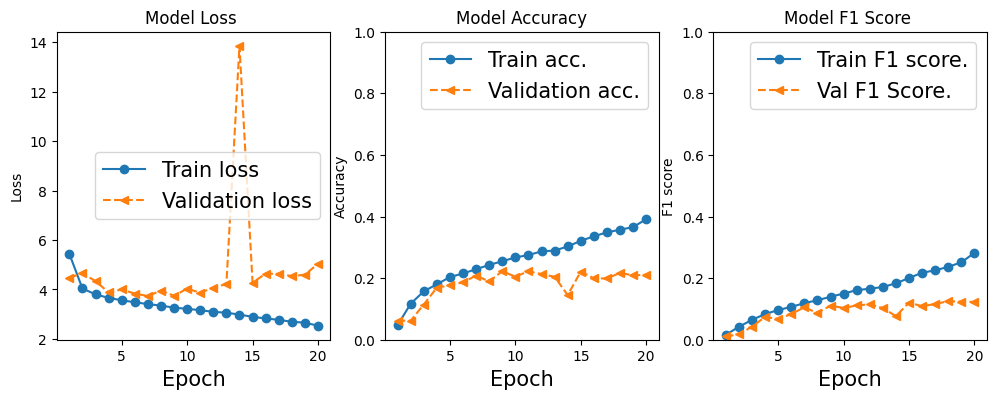

final train acc: 0.392
final val acc:   0.211

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


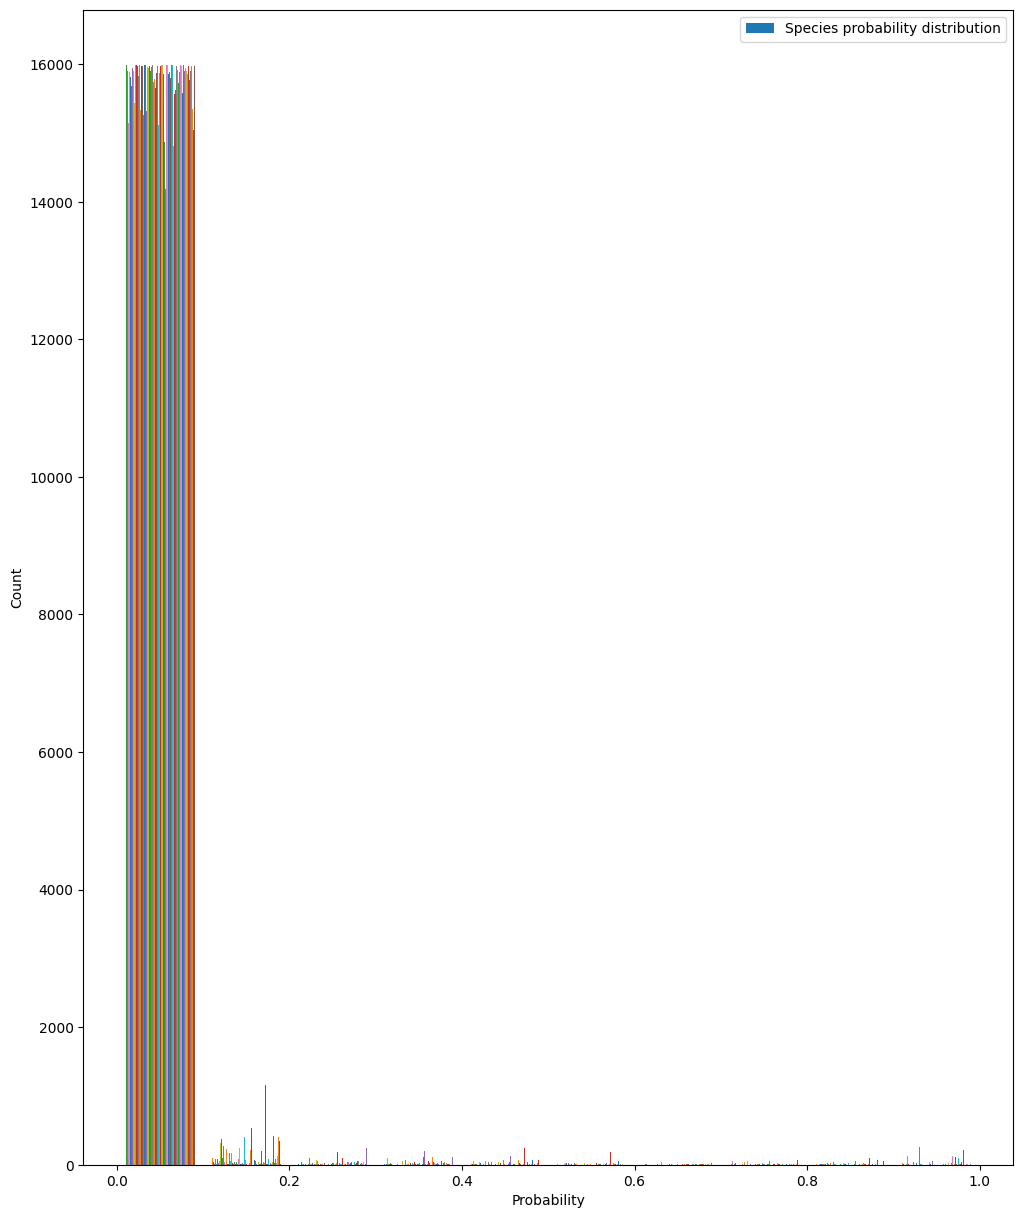

              precision    recall  f1-score   support

     amakin1       0.29      0.11      0.16        55
      amekes       0.67      0.29      0.40       251
     ampkin1       1.00      0.18      0.30        17
      anhing       0.37      0.23      0.29        60
      babwar       0.83      0.24      0.38       103
     bafibi1       0.50      0.12      0.19        17
      banana       0.51      0.79      0.62       359
      baymac       0.32      0.21      0.26        94
      bbwduc       0.87      0.19      0.31       246
     bicwre1       0.83      0.44      0.57        57
      bkcdon       0.53      0.41      0.46       102
     bkmtou1       0.92      0.82      0.86       191
     blbgra1       0.81      0.67      0.73       233
     blbwre1       0.92      0.15      0.26        73
     blcant4       0.71      0.27      0.39        64
     blchaw1       0.50      0.24      0.33        33
     blcjay1       0.61      0.36      0.45        61
     blctit1       0.00    

In [243]:
species_model_aves = build_aves_model_3(X_aves_cnn.shape[1],
                                              y_aves_cnn.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_cnn,
    y_aves_cnn,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_cnn,
                      y_aves_cnn)

# Testing with spectrogram augmentation

In [244]:
X_aves_cnn_augm, y_aves_cnn_augm  = add_spectrogram_augmentation(X_aves_cnn,y_aves_cnn )


Reshaped spectrogram shape :  (15993, 64, 64)
Augmented spectrograms shape:  (15993, 64, 64)
Reshaped Augmented spectrograms shape:  (15993, 64, 64, 1)
After augmentation: X shape: (31986, 64, 64, 1)
After augmentation: y shape: (31986, 146)
After shuffling: X shape: (31986, 64, 64, 1)
After shuffling: y shape: (31986, 146)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │        18,834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,866 (2.77 MB)

 Trainable params: 725,970 (2.77 MB)

 Non-trainable params: 896 (3.50 KB)

None
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.0384 - f1_score: 0.0146 - loss: 5.4897 - val_accuracy: 0.0684 - val_f1_score: 0.0218 - val_loss: 4.3926
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1253 - f1_score: 0.0477 - loss: 4.0334 - val_accuracy: 0.0973 - val_f1_score: 0.0423 - val_loss: 4.3135
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1563 - f1_score: 0.0660 - loss: 3.8377 - val_accuracy: 0.1817 - val_f1_score: 0.0709 - val_loss: 3.8832
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1760 - f1_score: 0.0815 - loss: 3.7548 - val_accuracy: 0.1922 - val_f1_score: 0.0865 - val_loss: 3.8150
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1853 - f1_score: 0.0905 - loss: 3.6903 - val_accuracy: 0.2307 - val_f1_score: 0.1066 - val_loss: 3.6231
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1983 - f1_score: 0.1022 - loss: 3.5978 - val_accuracy: 0.2253 - val_f1_score:

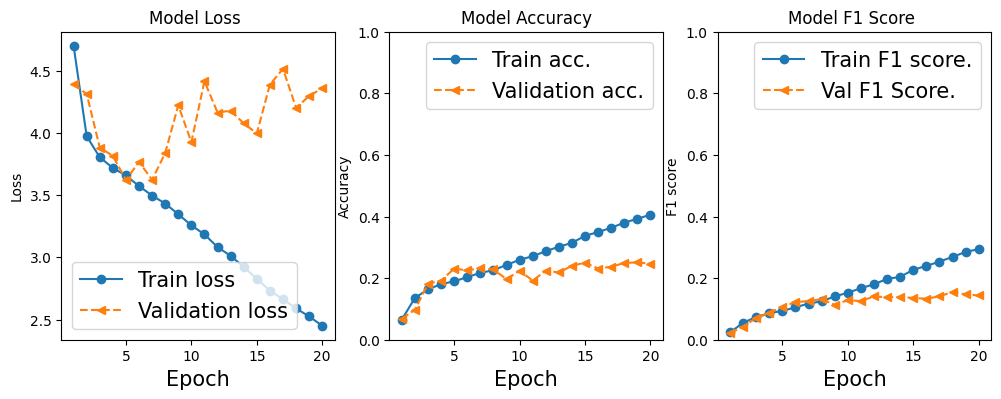

final train acc: 0.406
final val acc:   0.247

Unable to calculate percent diff as Train accuracy is zero
test_label length :  31986
predicted_labels length :  31986
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


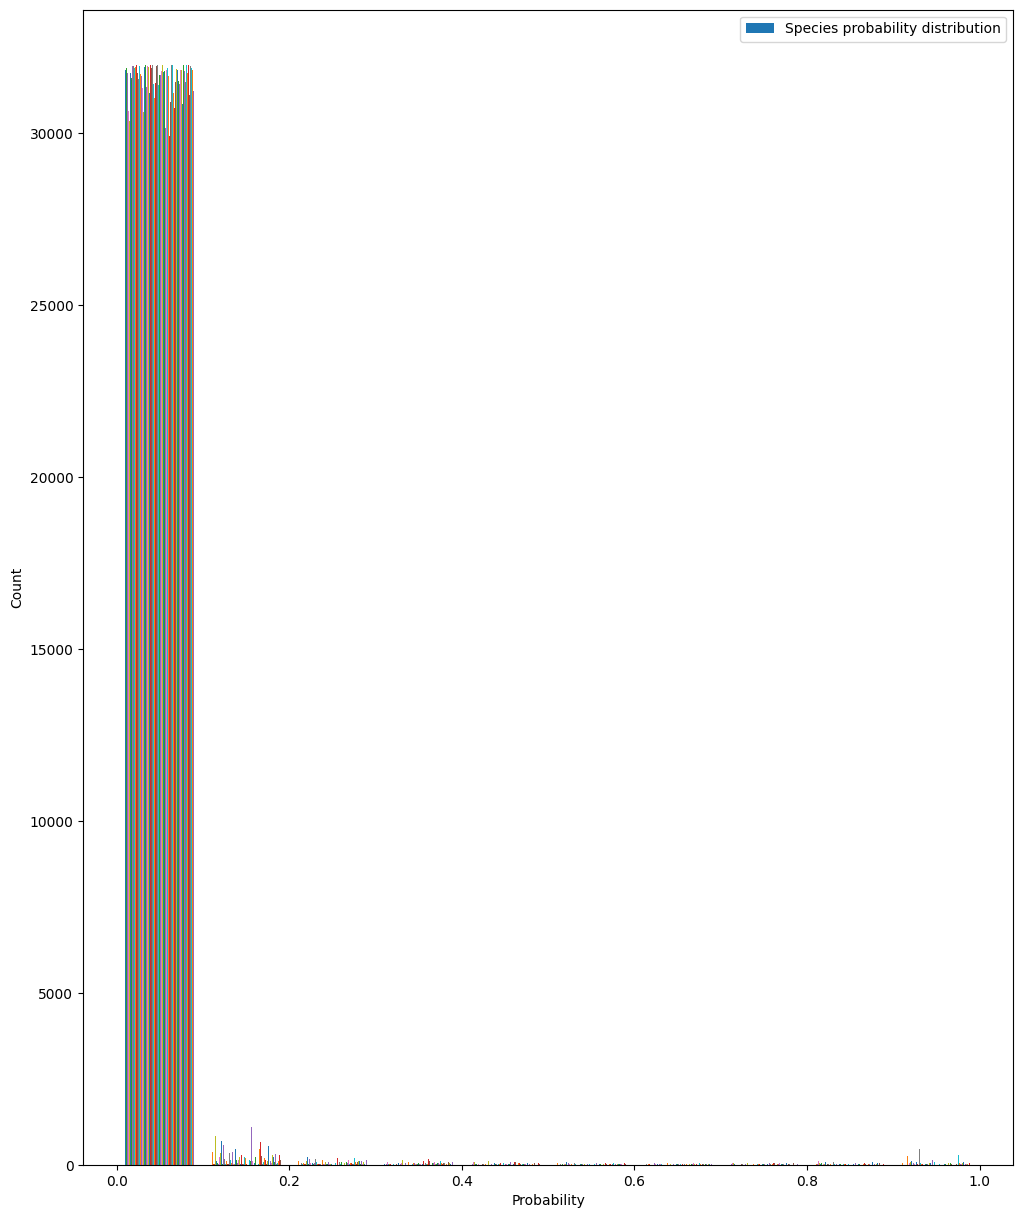

              precision    recall  f1-score   support

     amakin1       0.57      0.32      0.41       110
      amekes       0.52      0.49      0.50       502
     ampkin1       0.44      0.56      0.49        34
      anhing       0.89      0.07      0.12       120
      babwar       0.89      0.37      0.52       206
     bafibi1       0.60      0.26      0.37        34
      banana       0.62      0.88      0.73       718
      baymac       0.57      0.47      0.51       188
      bbwduc       0.34      0.70      0.46       492
     bicwre1       0.94      0.26      0.41       114
      bkcdon       0.76      0.49      0.60       204
     bkmtou1       0.72      0.80      0.75       382
     blbgra1       0.93      0.59      0.72       466
     blbwre1       0.73      0.47      0.57       146
     blcant4       1.00      0.04      0.08       128
     blchaw1       0.48      0.18      0.26        66
     blcjay1       0.36      0.68      0.47       122
     blctit1       0.27    

In [245]:
species_model_aves = build_aves_model_3(X_aves_cnn_augm.shape[1],
                                              y_aves_cnn_augm.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_cnn_augm,
    y_aves_cnn_augm,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_cnn_augm,
                      y_aves_cnn_augm)

In [246]:
X_aves_augm, y_aves_augm  = add_spectrogram_augmentation(X_aves_train,y_aves_train )


Reshaped spectrogram shape :  (16588, 64, 64)
Augmented spectrograms shape:  (16588, 64, 64)
Reshaped Augmented spectrograms shape:  (16588, 64, 64, 1)
After augmentation: X shape: (33176, 64, 64, 1)
After augmentation: y shape: (33176, 146)
After shuffling: X shape: (33176, 64, 64, 1)
After shuffling: y shape: (33176, 146)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 146)            │        18,834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,866 (2.77 MB)

 Trainable params: 725,970 (2.77 MB)

 Non-trainable params: 896 (3.50 KB)

None
Epoch 1/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.0353 - f1_score: 0.0126 - loss: 5.4805 - val_accuracy: 0.1163 - val_f1_score: 0.0319 - val_loss: 4.0073
Epoch 2/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1245 - f1_score: 0.0451 - loss: 4.0479 - val_accuracy: 0.1694 - val_f1_score: 0.0726 - val_loss: 3.7728
Epoch 3/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1525 - f1_score: 0.0629 - loss: 3.8819 - val_accuracy: 0.1774 - val_f1_score: 0.0814 - val_loss: 3.7255
Epoch 4/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1642 - f1_score: 0.0727 - loss: 3.8010 - val_accuracy: 0.1584 - val_f1_score: 0.0626 - val_loss: 3.9730
Epoch 5/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1814 - f1_score: 0.0867 - loss: 3.7236 - val_accuracy: 0.1660 - val_f1_score: 0.0748 - val_loss: 3.9301
Epoch 6/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1949 - f1_score: 0.0950 - loss: 3.6438 - val_accuracy: 0.1825 - val_f1_score:

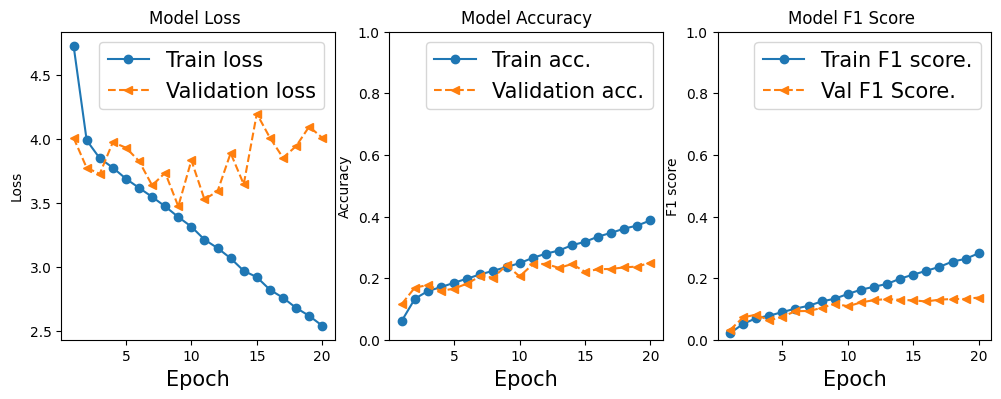

final train acc: 0.388
final val acc:   0.250

Unable to calculate percent diff as Train accuracy is zero
test_label length :  33176
predicted_labels length :  33176
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


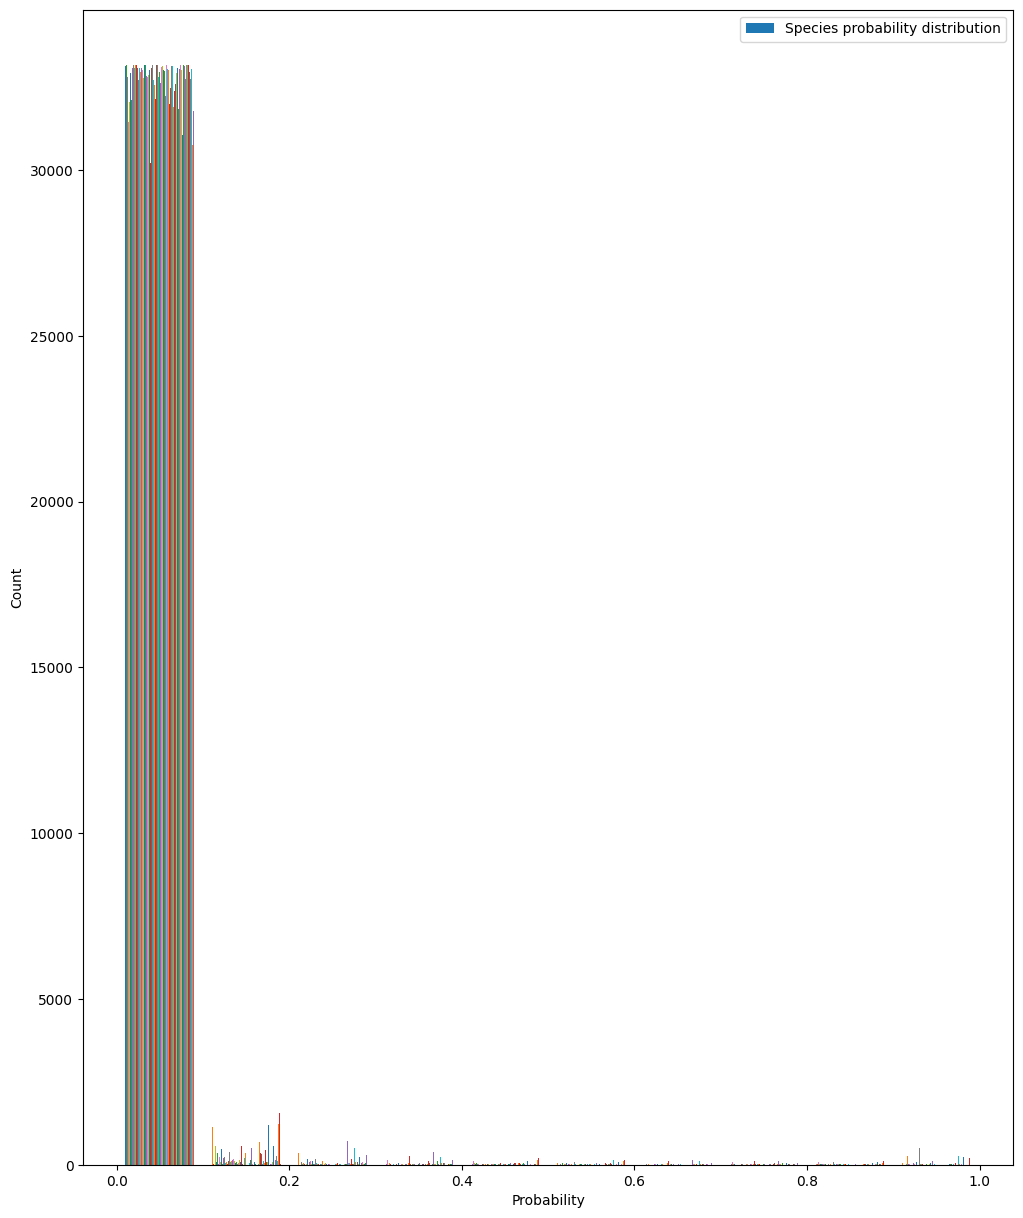

              precision    recall  f1-score   support

     amakin1       0.86      0.11      0.19       110
      amekes       0.29      0.55      0.38       502
     ampkin1       1.00      0.15      0.26        34
      anhing       0.60      0.05      0.09       120
      babwar       0.51      0.27      0.35       206
     bafibi1       0.00      0.00      0.00        34
      banana       0.46      0.74      0.57       718
      baymac       0.50      0.54      0.52       188
      bbwduc       0.47      0.52      0.50       492
     bicwre1       0.93      0.32      0.48       114
      bkcdon       0.78      0.54      0.64       204
     bkmtou1       0.69      0.79      0.73       382
     blbgra1       0.61      0.80      0.69       466
     blbwre1       0.75      0.33      0.46       146
     blcant4       0.81      0.42      0.55       128
     blchaw1       0.67      0.09      0.16        66
     blcjay1       0.41      0.56      0.47       122
     blctit1       0.00    

In [247]:
species_model_aves = build_aves_model_3(X_aves_augm.shape[1],
                                              y_aves_augm.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_augm,
    y_aves_augm,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_augm,
                      y_aves_augm)

#  Hypertuning Model Parmeters

So far, we have attempted the following:  
- different model depths,
- data undersampling,
- data augmentation

Next, we will attempt the following Hyperparameter tuning  using Model 3 with CondensedNearestNeighbor UnderSampling data.

|Model|conv blocks|dense layers|conv_dropout|dense_dropouut|batch|epochs|learning_rate|optimizer|kernel|stride|macro_f1|accuracy avg|yectyr1 recall|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(2,2)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(8,8)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|16|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|64|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|RMSprop|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|SGD|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.1|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.001|Adam|(4,4)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(1,1)|(2,2)||||
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(1,1)|(2,2)||||

In [248]:
def build_model_tuning_model_1(img_size, output_size, **kwargs):
  """ Model will be based on model 3 with configurable hyper parameters to aid tuninig
  """
  #set defaults
  maxpool=(2,2)
  learn_rate=0.01
  kernel=(4,4)
  optimizer='Adam'
  stride=(2,2)

  dropout = 0.2
  dropout_dense = 0.3

  keys = kwargs.keys()
  for key in keys:
    if key == 'maxpool': maxpool=kwargs['maxpool']
    if key == 'learn_rate': learn_rate=kwargs['learn_rate']
    if key == 'kernel': kernel=kwargs['kernel']
    if key == 'optimizer': optimizer=kwargs['optimizer']
    if key == 'stride': stride=kwargs['stride']


  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D(maxpool)(normal_1)
 # dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D(maxpool)(normal_2)
 # dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

  # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(maxpool_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D(maxpool)(normal_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  flat_1 = tf.keras.layers.GlobalAveragePooling2D()(dropout_3)
  dense_1 = tf.keras.layers.Dense(128)(flat_1)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_1)
  dense_2 = tf.keras.layers.Dense(128)(dropout_4)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_5)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')


  # compile model
  if optimizer == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  elif optimizer == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=learn_rate)
  model.compile(
      optimizer=opt,
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])

  #print(model.summary())
  return model

In [249]:
def evaluate_tuning_model_1(train_data,
                            label_data,
                            batch='default',
                            maxpool='default',
                            learn_rate='default',
                            kernel='default',
                            optimizer='default',
                            stride='default'):
  """ Build and Train model based on input parameters and display results
  """
  print(f"Running Tuning model with parameter values: " ,
          f" \nbatch={batch} \nmaxpool={maxpool} \nlearn_rate={learn_rate} \nkernel={kernel} \noptimizer={optimizer} \nstride={stride}"  )

  if maxpool != 'default':
    print("Tuning maxpool")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     maxpool=maxpool)
  elif learn_rate != 'default':
    print("Tuning learn_rate")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     learn_rate=learn_rate)
  elif kernel != 'default':
    print("Tuning kernel")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     kernel=kernel)
  elif optimizer != 'default':
    print("Tuning optimizer")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     optimizer=optimizer)
  elif stride != 'default':
    print("Tuning stride")
    model = build_model_tuning_model_1(train_data.shape[1],
                                      label_data.shape[1],
                                      stride=stride)
  else:
    print("Tuning Batch Size")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1])

  # train model on (X_train, y_train) data
  if batch == 'default': batch = 32
  history = model.fit(
      train_data,
      label_data,
      validation_data=(X_aves_val,y_aves_val),
      callbacks=[ reduce_lr_f1],
      batch_size=batch,
      epochs=20)

  # plot loss curves
  show_history(history)

  #plot confusion matrix
  plot_confusion_matrix(model, train_data, label_data)
  return model

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=2 
optimizer=default 
stride=default
Tuning kernel
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.0000e+00 - f1_score: 0.0132 - loss: 5.8204 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0087 - val_loss: 4.8639 - learning_rate: 0.0100
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.0337 - loss: 4.2354 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0354 - val_loss: 4.2565 - learning_rate: 0.0100
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.0423 - loss: 4.1229 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0400 - val_loss: 4.2810 - learning_rate: 0.0100
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.0445 - loss: 4.0918 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0426 - val_loss: 4.4549 - learning_rate: 0.0100
Epoch 5/20
500/500 ━━━━━━━━━━━━━━

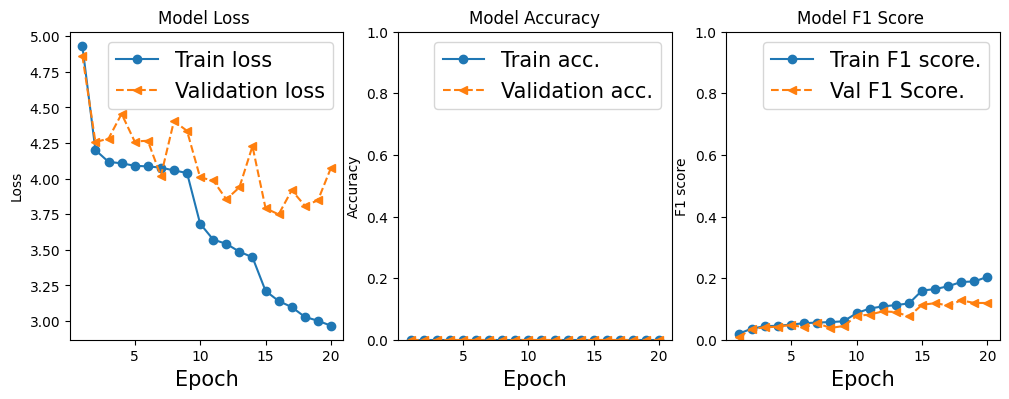

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


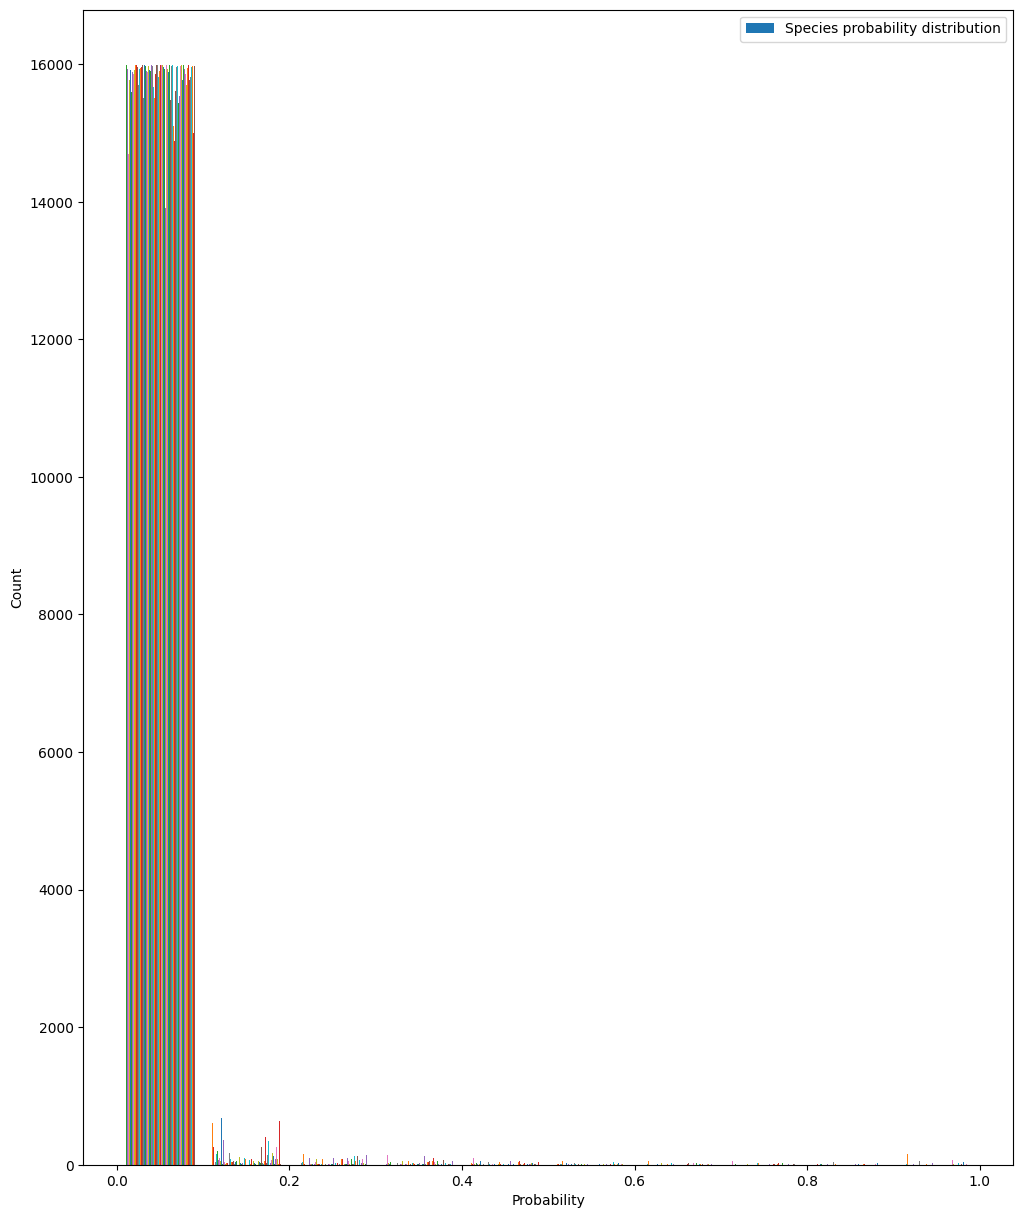

              precision    recall  f1-score   support

     amakin1       0.67      0.04      0.07        55
      amekes       0.19      0.46      0.27       251
     ampkin1       0.00      0.00      0.00        17
      anhing       0.12      0.40      0.18        60
      babwar       0.73      0.16      0.26       103
     bafibi1       1.00      0.06      0.11        17
      banana       0.31      0.83      0.45       359
      baymac       0.56      0.26      0.35        94
      bbwduc       0.60      0.24      0.34       246
     bicwre1       0.21      0.56      0.31        57
      bkcdon       0.69      0.22      0.33       102
     bkmtou1       0.23      0.88      0.36       191
     blbgra1       0.62      0.45      0.52       233
     blbwre1       1.00      0.15      0.26        73
     blcant4       0.48      0.25      0.33        64
     blchaw1       0.00      0.00      0.00        33
     blcjay1       0.28      0.16      0.21        61
     blctit1       0.00    

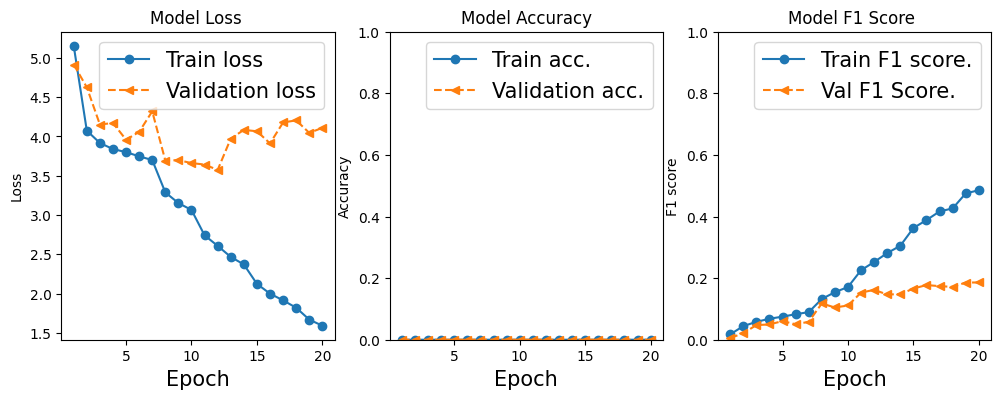

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


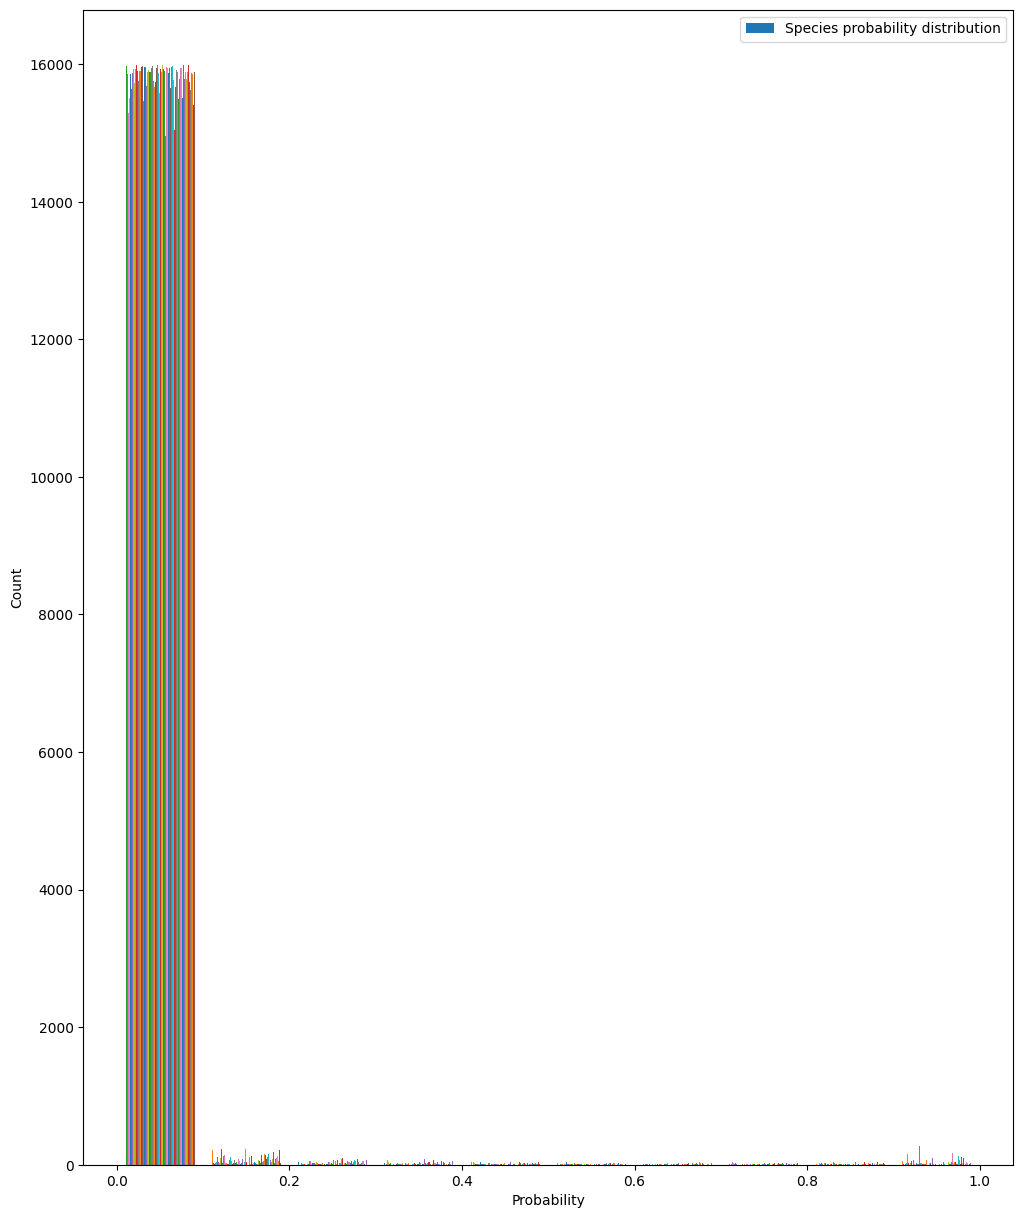

              precision    recall  f1-score   support

     amakin1       0.39      0.56      0.46        55
      amekes       0.57      0.75      0.65       251
     ampkin1       0.67      0.24      0.35        17
      anhing       0.73      0.27      0.39        60
      babwar       0.79      0.49      0.60       103
     bafibi1       1.00      0.53      0.69        17
      banana       0.66      0.88      0.75       359
      baymac       0.88      0.70      0.78        94
      bbwduc       0.61      0.73      0.67       246
     bicwre1       0.77      0.70      0.73        57
      bkcdon       0.79      0.66      0.72       102
     bkmtou1       0.95      0.88      0.91       191
     blbgra1       0.82      0.74      0.78       233
     blbwre1       0.85      0.64      0.73        73
     blcant4       0.73      0.67      0.70        64
     blchaw1       0.92      0.33      0.49        33
     blcjay1       0.90      0.57      0.70        61
     blctit1       1.00    

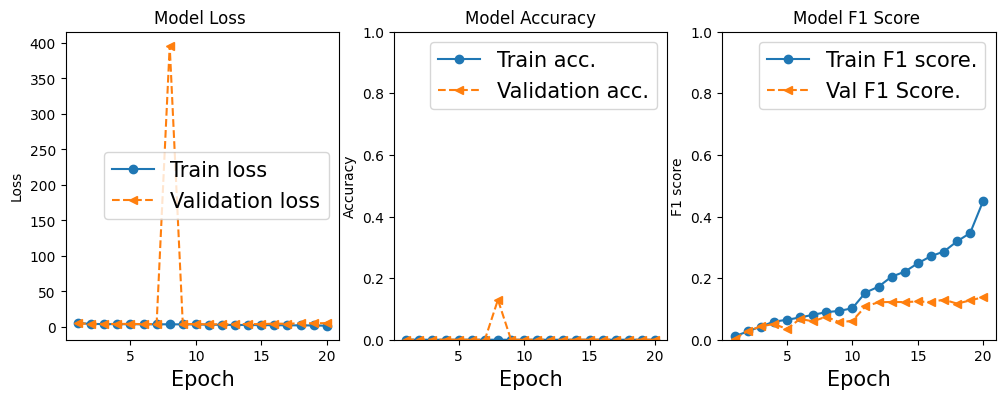

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


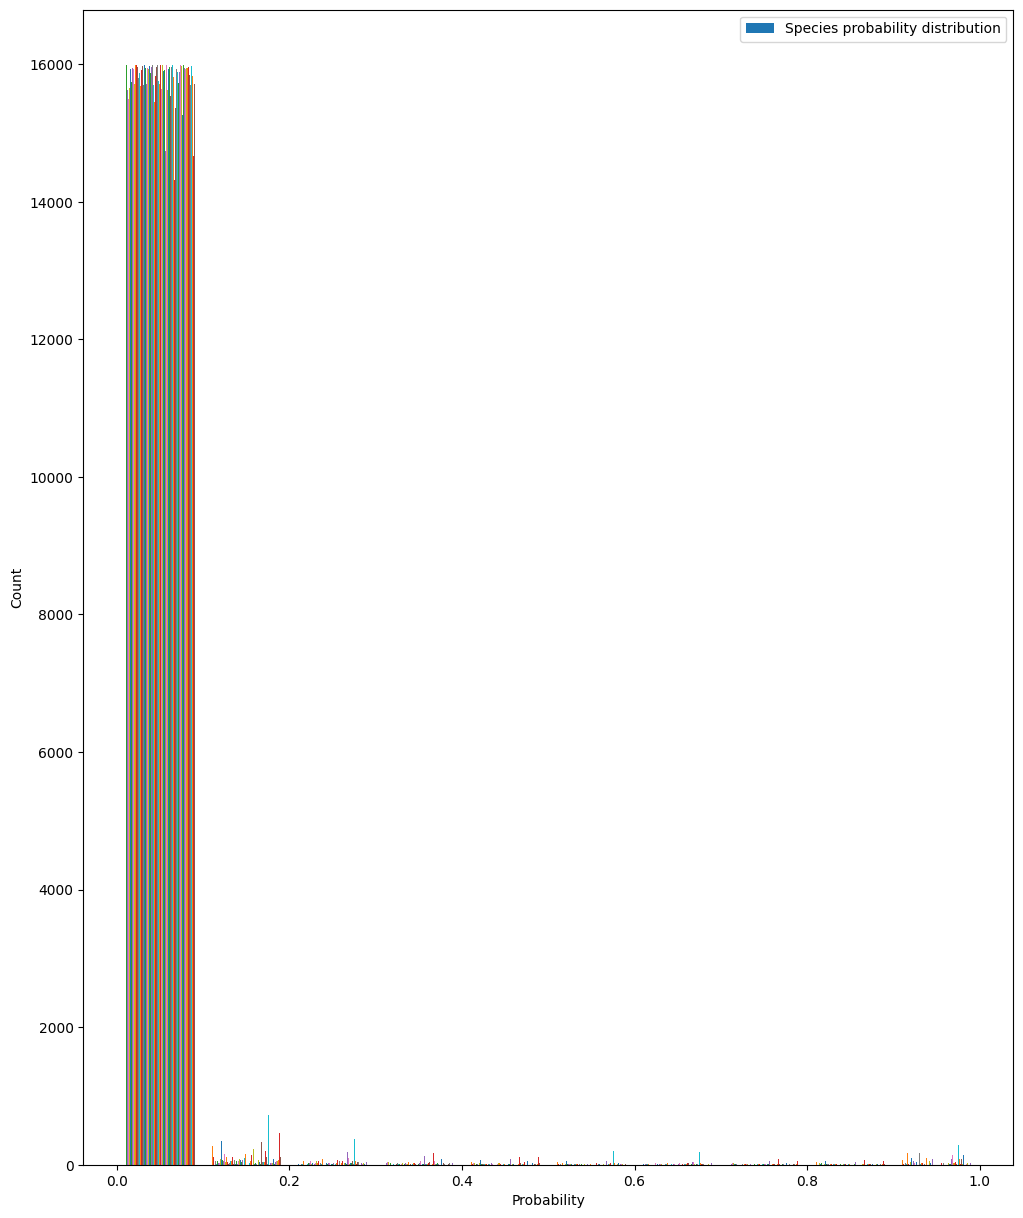

              precision    recall  f1-score   support

     amakin1       0.45      0.18      0.26        55
      amekes       0.41      0.61      0.49       251
     ampkin1       0.80      0.24      0.36        17
      anhing       0.26      0.33      0.29        60
      babwar       0.39      0.53      0.45       103
     bafibi1       0.80      0.24      0.36        17
      banana       0.77      0.73      0.75       359
      baymac       0.61      0.51      0.55        94
      bbwduc       0.62      0.44      0.52       246
     bicwre1       0.69      0.47      0.56        57
      bkcdon       0.86      0.31      0.46       102
     bkmtou1       0.55      0.92      0.69       191
     blbgra1       0.87      0.69      0.77       233
     blbwre1       1.00      0.22      0.36        73
     blcant4       0.81      0.34      0.48        64
     blchaw1       1.00      0.15      0.26        33
     blcjay1       0.80      0.39      0.53        61
     blctit1       0.00    

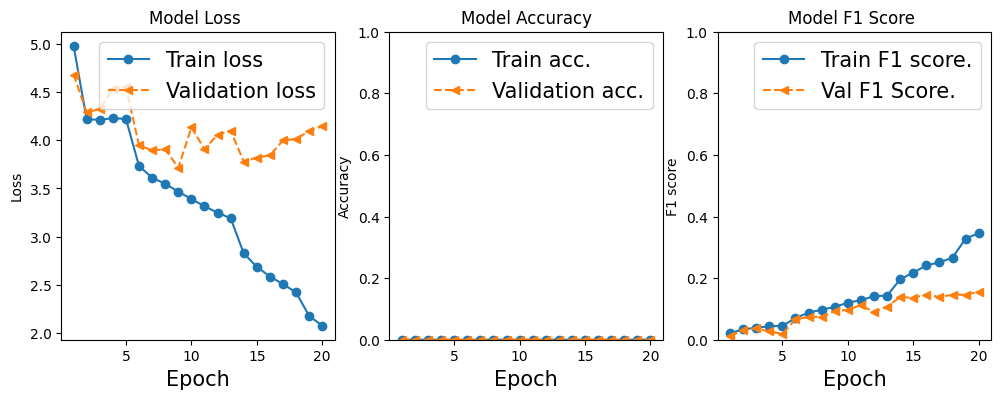

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


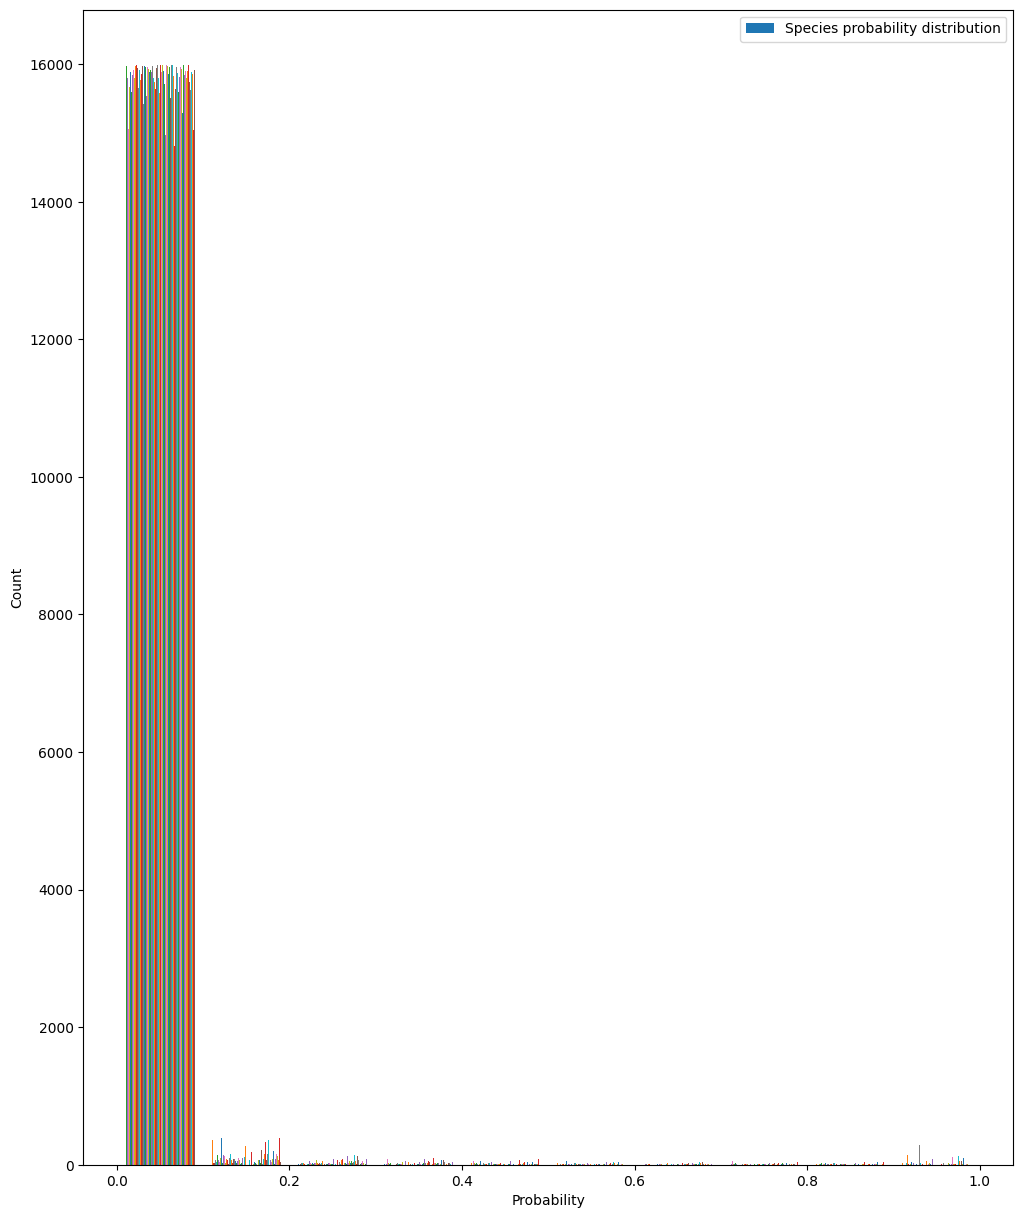

              precision    recall  f1-score   support

     amakin1       0.33      0.15      0.20        55
      amekes       0.39      0.63      0.48       251
     ampkin1       0.50      0.12      0.19        17
      anhing       0.92      0.18      0.31        60
      babwar       0.51      0.38      0.43       103
     bafibi1       0.54      0.41      0.47        17
      banana       0.51      0.86      0.64       359
      baymac       0.67      0.51      0.58        94
      bbwduc       0.58      0.47      0.52       246
     bicwre1       0.55      0.63      0.59        57
      bkcdon       0.81      0.41      0.55       102
     bkmtou1       0.78      0.90      0.83       191
     blbgra1       0.80      0.59      0.68       233
     blbwre1       0.72      0.42      0.53        73
     blcant4       0.47      0.55      0.51        64
     blchaw1       0.80      0.12      0.21        33
     blcjay1       0.74      0.38      0.50        61
     blctit1       0.00    

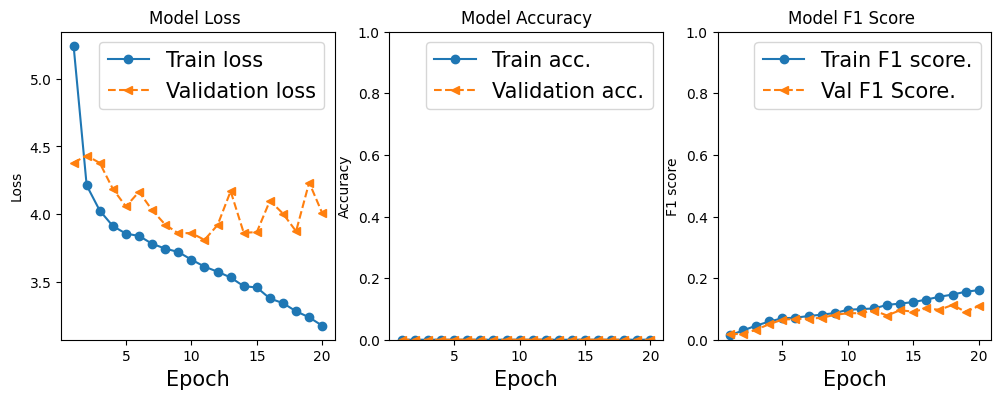

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


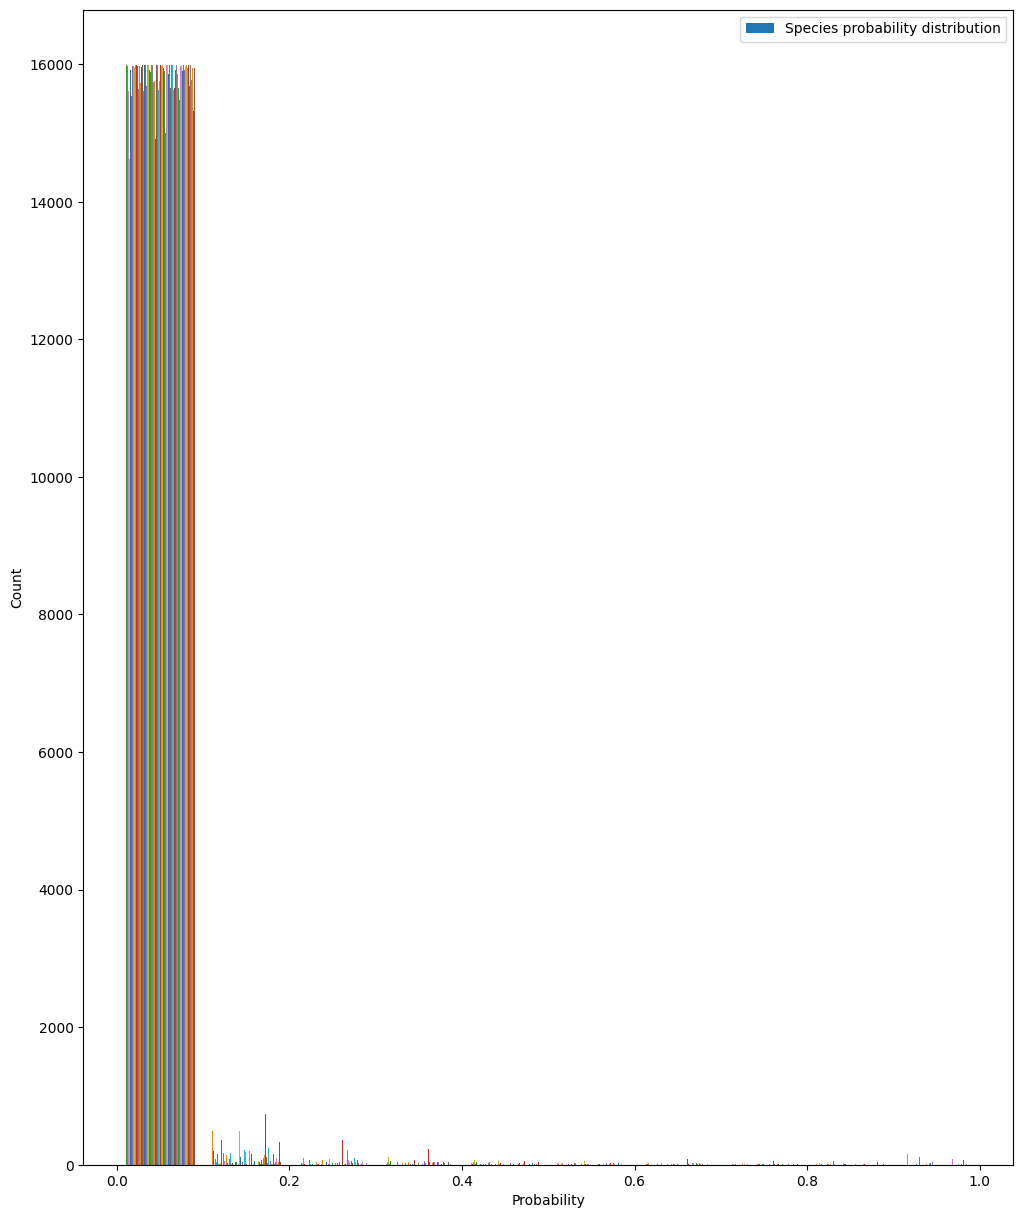

              precision    recall  f1-score   support

     amakin1       0.00      0.00      0.00        55
      amekes       0.22      0.57      0.32       251
     ampkin1       0.00      0.00      0.00        17
      anhing       0.12      0.28      0.17        60
      babwar       0.75      0.09      0.16       103
     bafibi1       0.00      0.00      0.00        17
      banana       0.73      0.52      0.60       359
      baymac       0.40      0.27      0.32        94
      bbwduc       0.18      0.68      0.29       246
     bicwre1       0.77      0.40      0.53        57
      bkcdon       0.66      0.19      0.29       102
     bkmtou1       0.32      0.91      0.47       191
     blbgra1       0.59      0.70      0.64       233
     blbwre1       0.81      0.18      0.29        73
     blcant4       0.86      0.09      0.17        64
     blchaw1       0.00      0.00      0.00        33
     blcjay1       0.83      0.08      0.15        61
     blctit1       0.00    

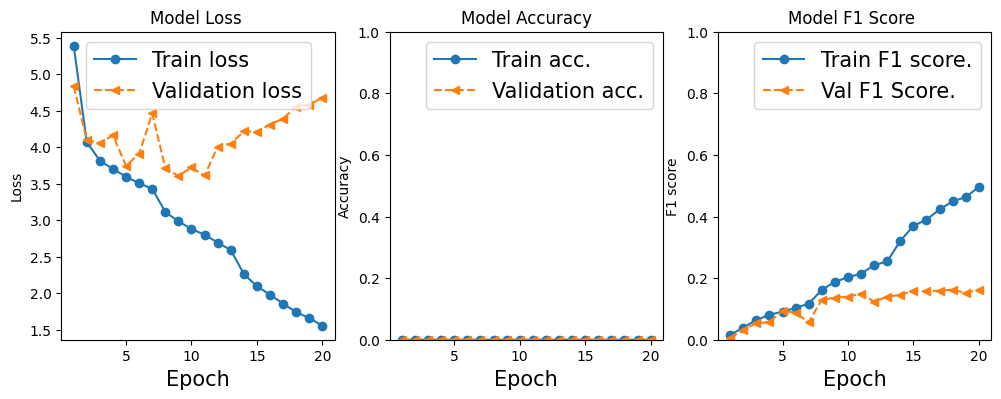

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


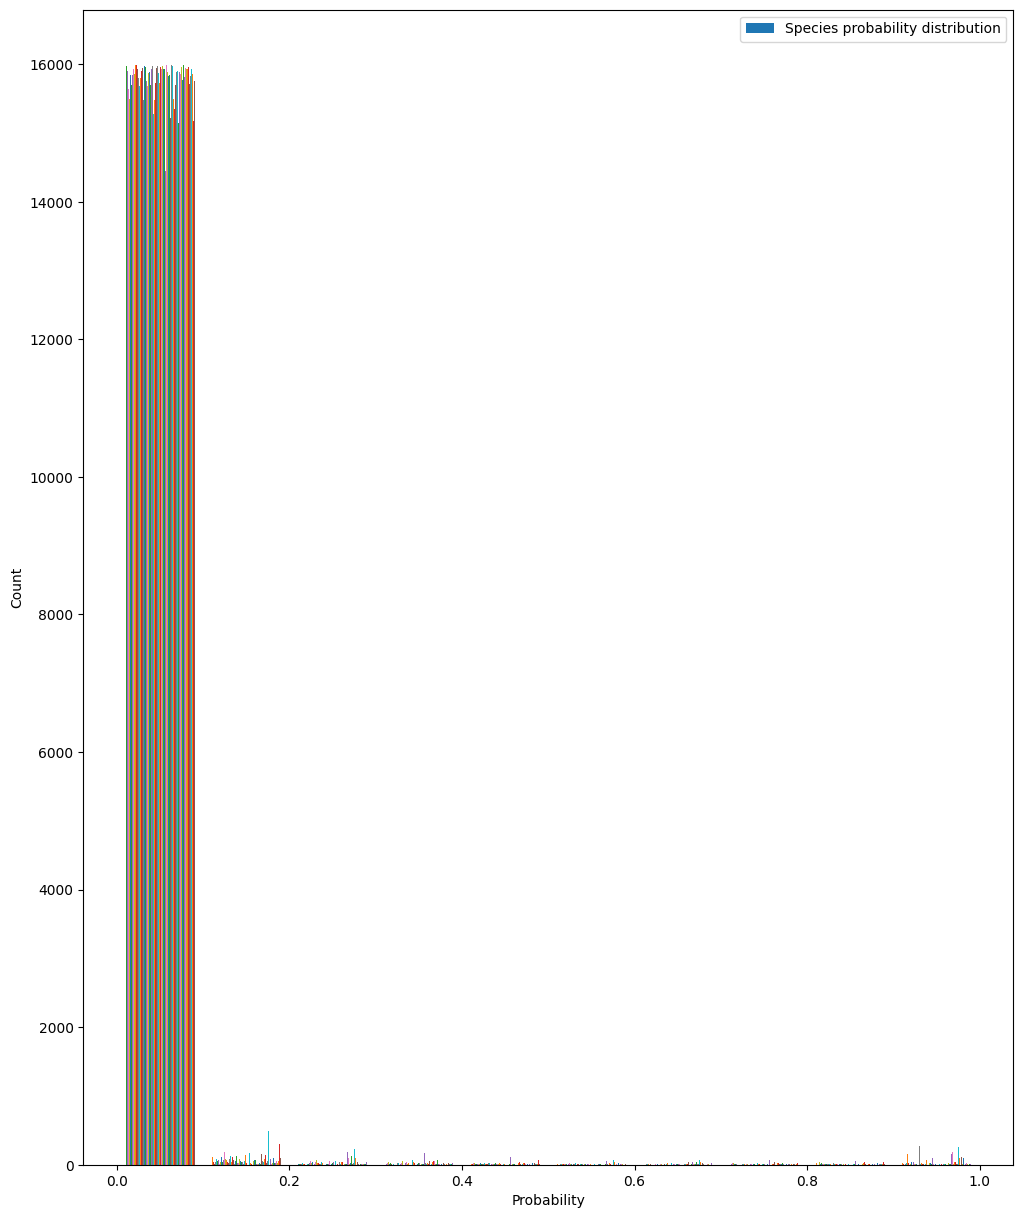

              precision    recall  f1-score   support

     amakin1       0.78      0.13      0.22        55
      amekes       0.84      0.53      0.65       251
     ampkin1       0.50      0.12      0.19        17
      anhing       0.66      0.38      0.48        60
      babwar       0.89      0.40      0.55       103
     bafibi1       0.56      0.29      0.38        17
      banana       0.92      0.72      0.81       359
      baymac       0.83      0.48      0.61        94
      bbwduc       0.58      0.72      0.64       246
     bicwre1       0.53      0.72      0.61        57
      bkcdon       0.72      0.56      0.63       102
     bkmtou1       0.82      0.89      0.85       191
     blbgra1       0.86      0.81      0.83       233
     blbwre1       0.79      0.56      0.66        73
     blcant4       0.50      0.59      0.54        64
     blchaw1       0.94      0.45      0.61        33
     blcjay1       0.84      0.44      0.58        61
     blctit1       0.00    

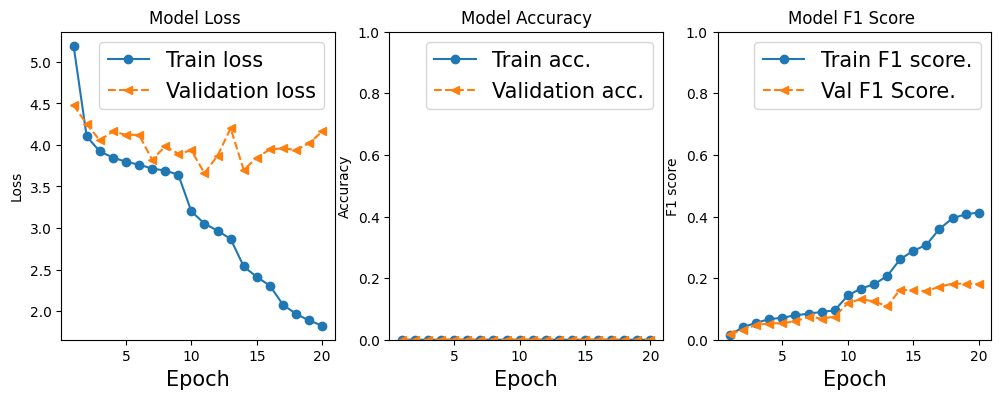

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


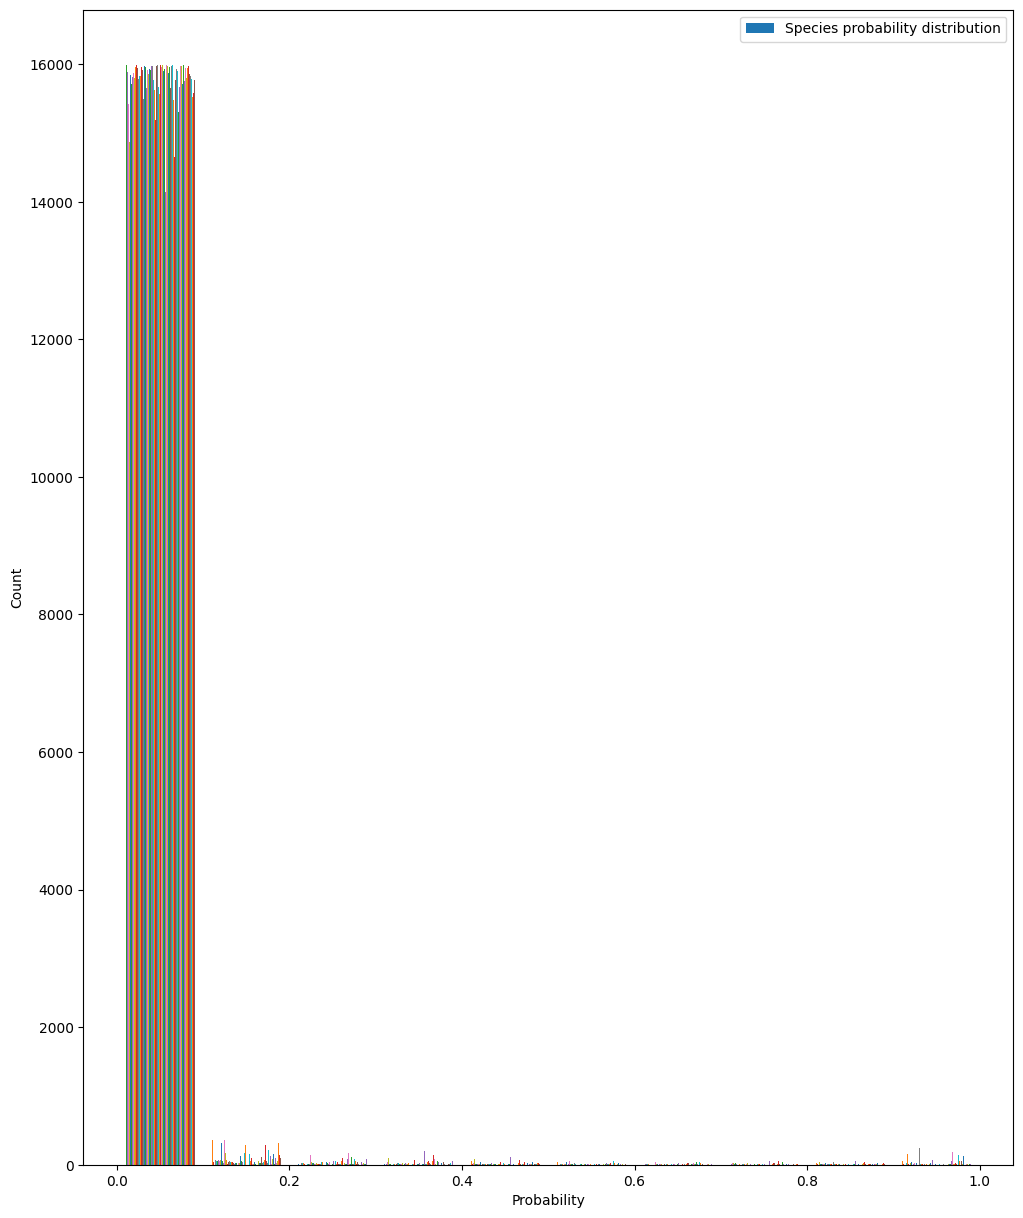

              precision    recall  f1-score   support

     amakin1       0.40      0.18      0.25        55
      amekes       0.41      0.80      0.55       251
     ampkin1       0.67      0.12      0.20        17
      anhing       0.58      0.43      0.50        60
      babwar       0.90      0.46      0.61       103
     bafibi1       1.00      0.24      0.38        17
      banana       0.76      0.84      0.80       359
      baymac       0.73      0.60      0.65        94
      bbwduc       0.33      0.78      0.46       246
     bicwre1       0.65      0.70      0.67        57
      bkcdon       0.70      0.56      0.62       102
     bkmtou1       0.90      0.88      0.89       191
     blbgra1       0.91      0.80      0.85       233
     blbwre1       1.00      0.32      0.48        73
     blcant4       0.48      0.67      0.56        64
     blchaw1       0.56      0.27      0.37        33
     blcjay1       0.67      0.59      0.63        61
     blctit1       0.00    

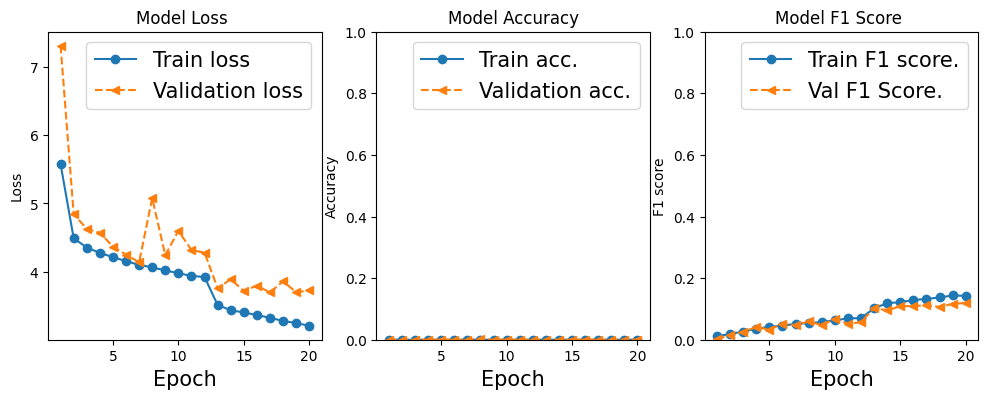

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


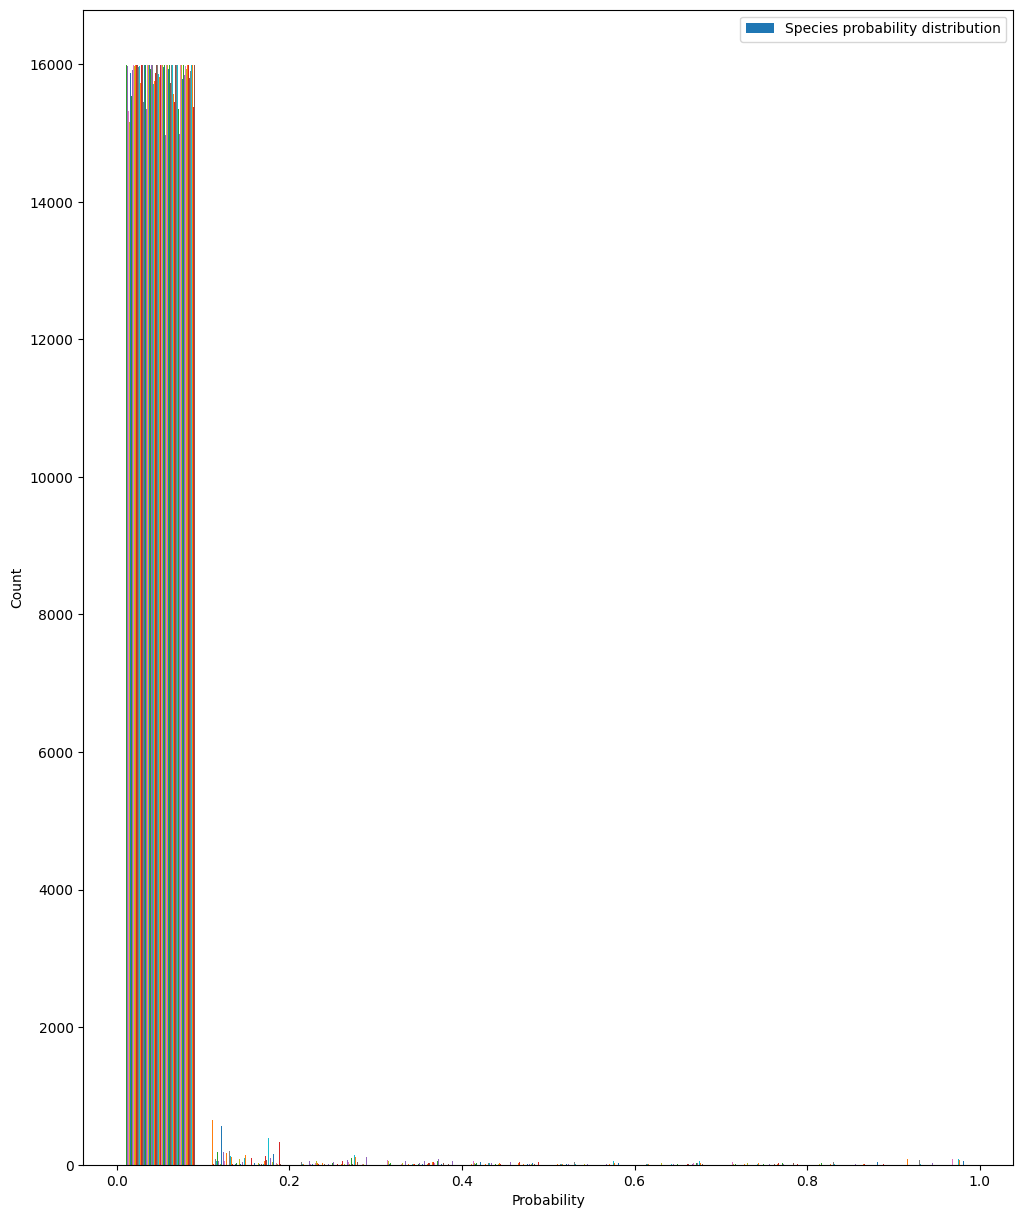

              precision    recall  f1-score   support

     amakin1       0.00      0.00      0.00        55
      amekes       0.16      0.68      0.25       251
     ampkin1       0.00      0.00      0.00        17
      anhing       0.45      0.08      0.14        60
      babwar       0.50      0.01      0.02       103
     bafibi1       0.00      0.00      0.00        17
      banana       0.51      0.80      0.62       359
      baymac       0.43      0.49      0.46        94
      bbwduc       0.22      0.63      0.32       246
     bicwre1       0.45      0.47      0.46        57
      bkcdon       0.43      0.33      0.38       102
     bkmtou1       0.98      0.76      0.86       191
     blbgra1       0.58      0.76      0.65       233
     blbwre1       0.00      0.00      0.00        73
     blcant4       0.52      0.42      0.47        64
     blchaw1       0.00      0.00      0.00        33
     blcjay1       0.00      0.00      0.00        61
     blctit1       0.00    

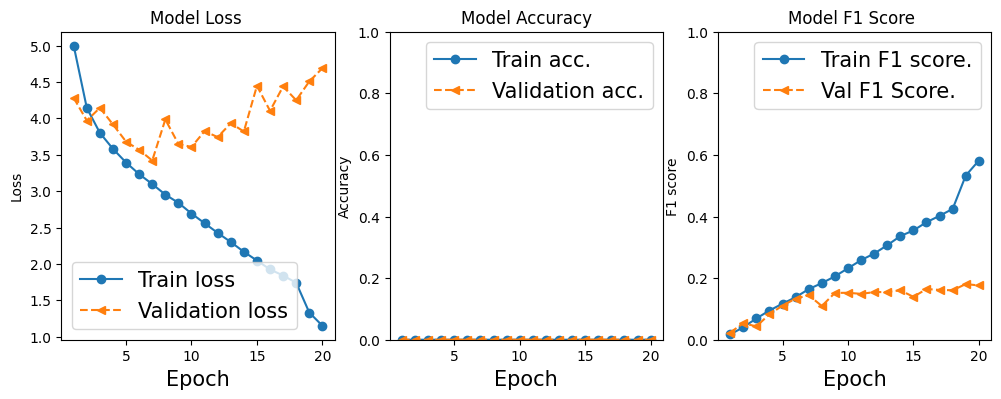

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


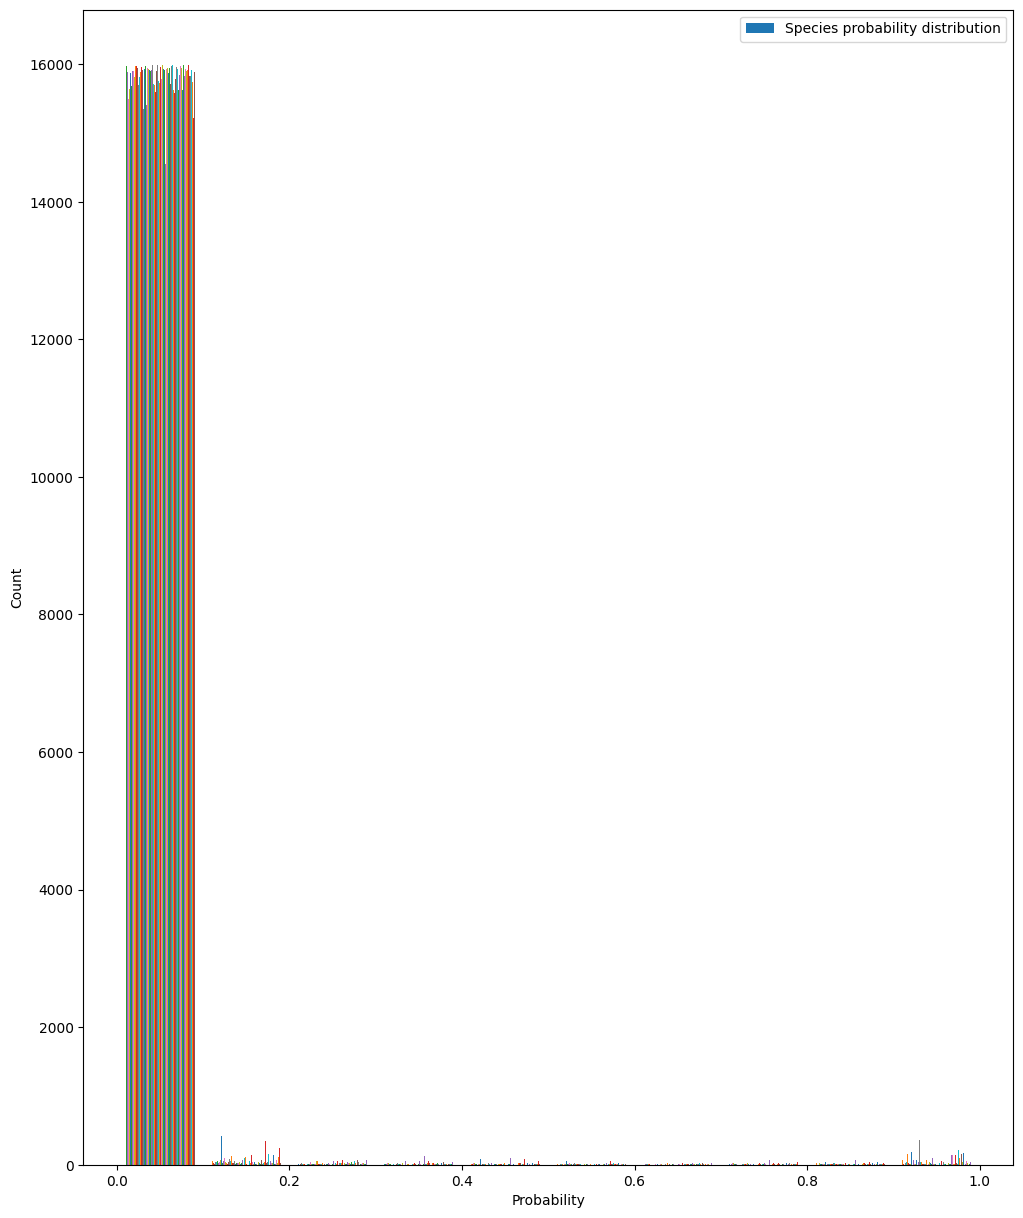

              precision    recall  f1-score   support

     amakin1       0.84      0.49      0.62        55
      amekes       0.95      0.63      0.76       251
     ampkin1       1.00      0.47      0.64        17
      anhing       0.77      0.45      0.57        60
      babwar       0.86      0.54      0.67       103
     bafibi1       0.83      0.29      0.43        17
      banana       0.83      0.91      0.87       359
      baymac       0.74      0.74      0.74        94
      bbwduc       0.81      0.78      0.79       246
     bicwre1       0.74      0.86      0.80        57
      bkcdon       0.92      0.71      0.80       102
     bkmtou1       0.86      0.95      0.90       191
     blbgra1       0.89      0.91      0.90       233
     blbwre1       0.82      0.67      0.74        73
     blcant4       0.87      0.73      0.80        64
     blchaw1       0.83      0.58      0.68        33
     blcjay1       0.90      0.75      0.82        61
     blctit1       0.75    

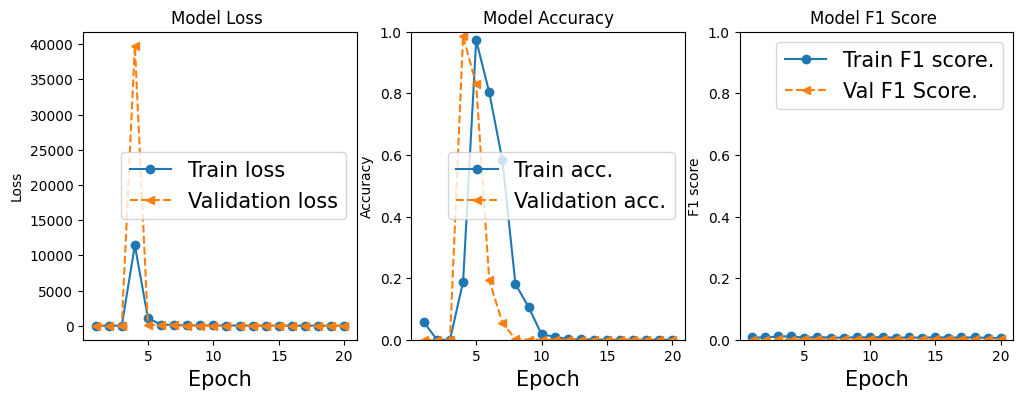

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


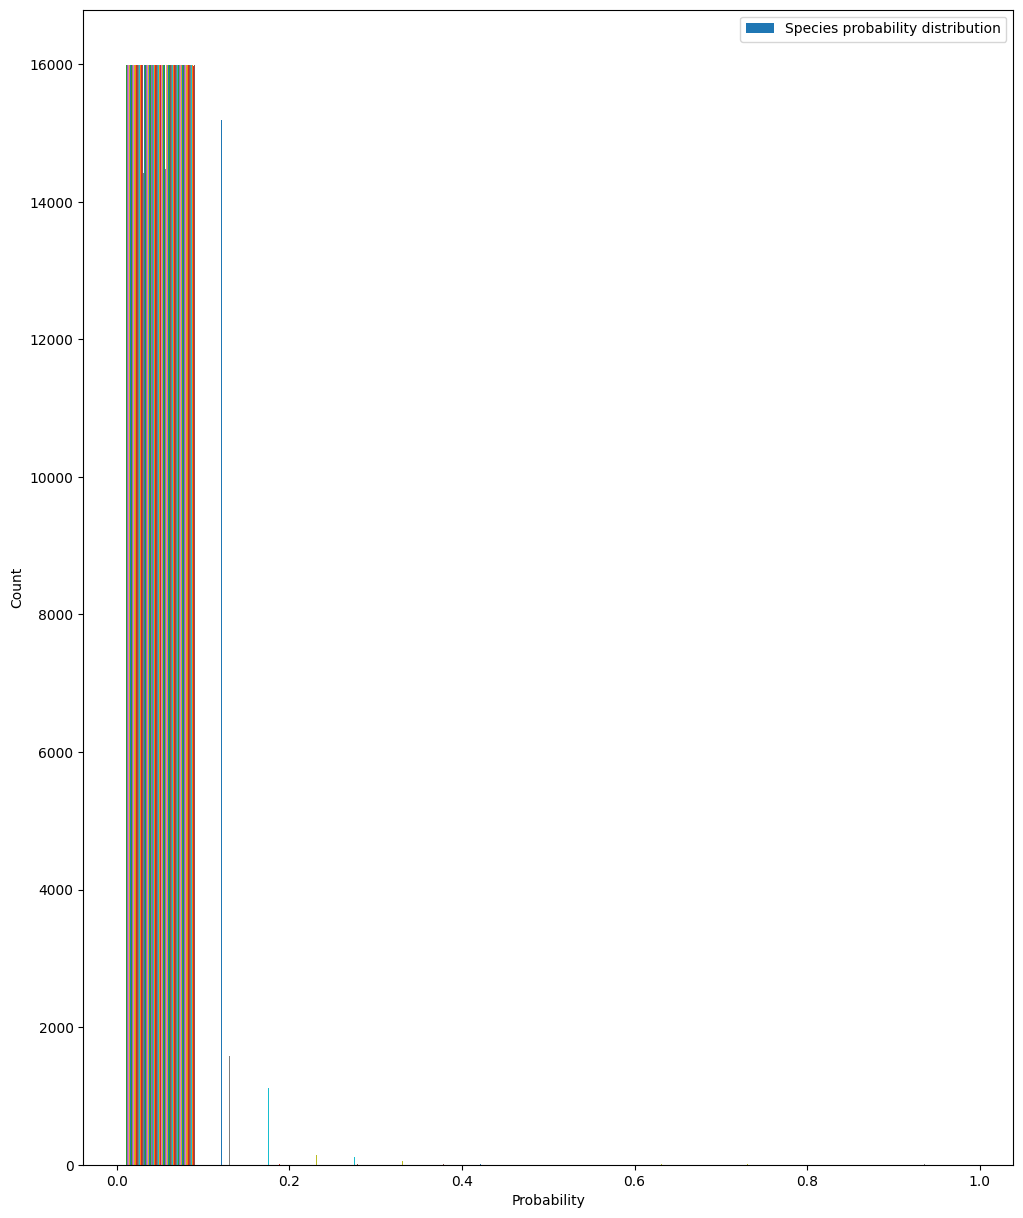

              precision    recall  f1-score   support

     amakin1       0.00      0.00      0.00        55
      amekes       0.00      0.00      0.00       251
     ampkin1       0.00      0.00      0.00        17
      anhing       0.00      0.00      0.00        60
      babwar       0.00      0.00      0.00       103
     bafibi1       0.00      0.00      0.00        17
      banana       0.00      0.00      0.00       359
      baymac       0.00      0.00      0.00        94
      bbwduc       0.00      0.00      0.00       246
     bicwre1       0.00      0.00      0.00        57
      bkcdon       0.00      0.00      0.00       102
     bkmtou1       0.00      0.00      0.00       191
     blbgra1       0.00      0.00      0.00       233
     blbwre1       0.00      0.00      0.00        73
     blcant4       0.00      0.00      0.00        64
     blchaw1       0.00      0.00      0.00        33
     blcjay1       0.00      0.00      0.00        61
     blctit1       0.00    

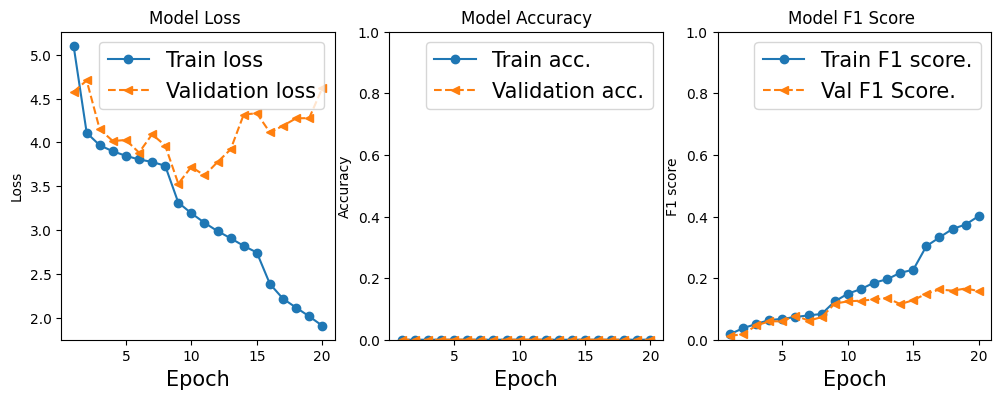

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


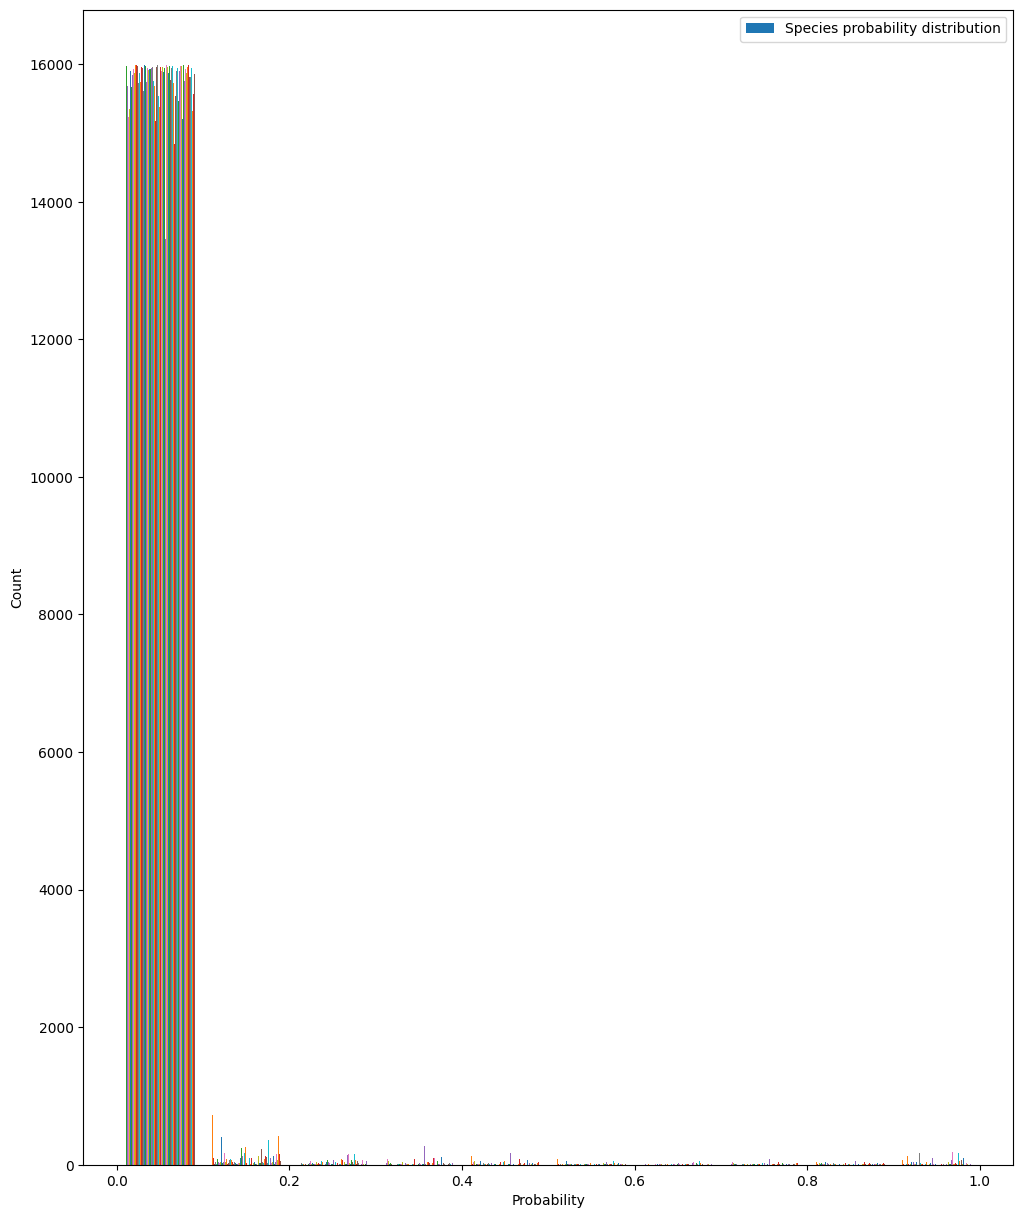

              precision    recall  f1-score   support

     amakin1       0.71      0.09      0.16        55
      amekes       0.22      0.82      0.35       251
     ampkin1       1.00      0.12      0.21        17
      anhing       0.26      0.33      0.29        60
      babwar       0.37      0.41      0.39       103
     bafibi1       1.00      0.24      0.38        17
      banana       0.63      0.85      0.73       359
      baymac       0.68      0.24      0.36        94
      bbwduc       0.49      0.57      0.53       246
     bicwre1       0.92      0.39      0.54        57
      bkcdon       0.83      0.54      0.65       102
     bkmtou1       0.93      0.82      0.87       191
     blbgra1       0.85      0.67      0.75       233
     blbwre1       0.96      0.30      0.46        73
     blcant4       0.48      0.66      0.55        64
     blchaw1       0.44      0.33      0.38        33
     blcjay1       0.79      0.36      0.49        61
     blctit1       0.50    

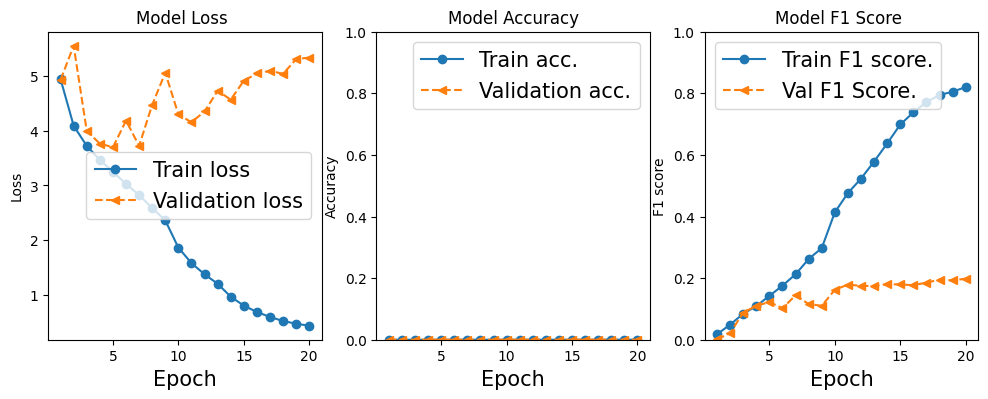

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


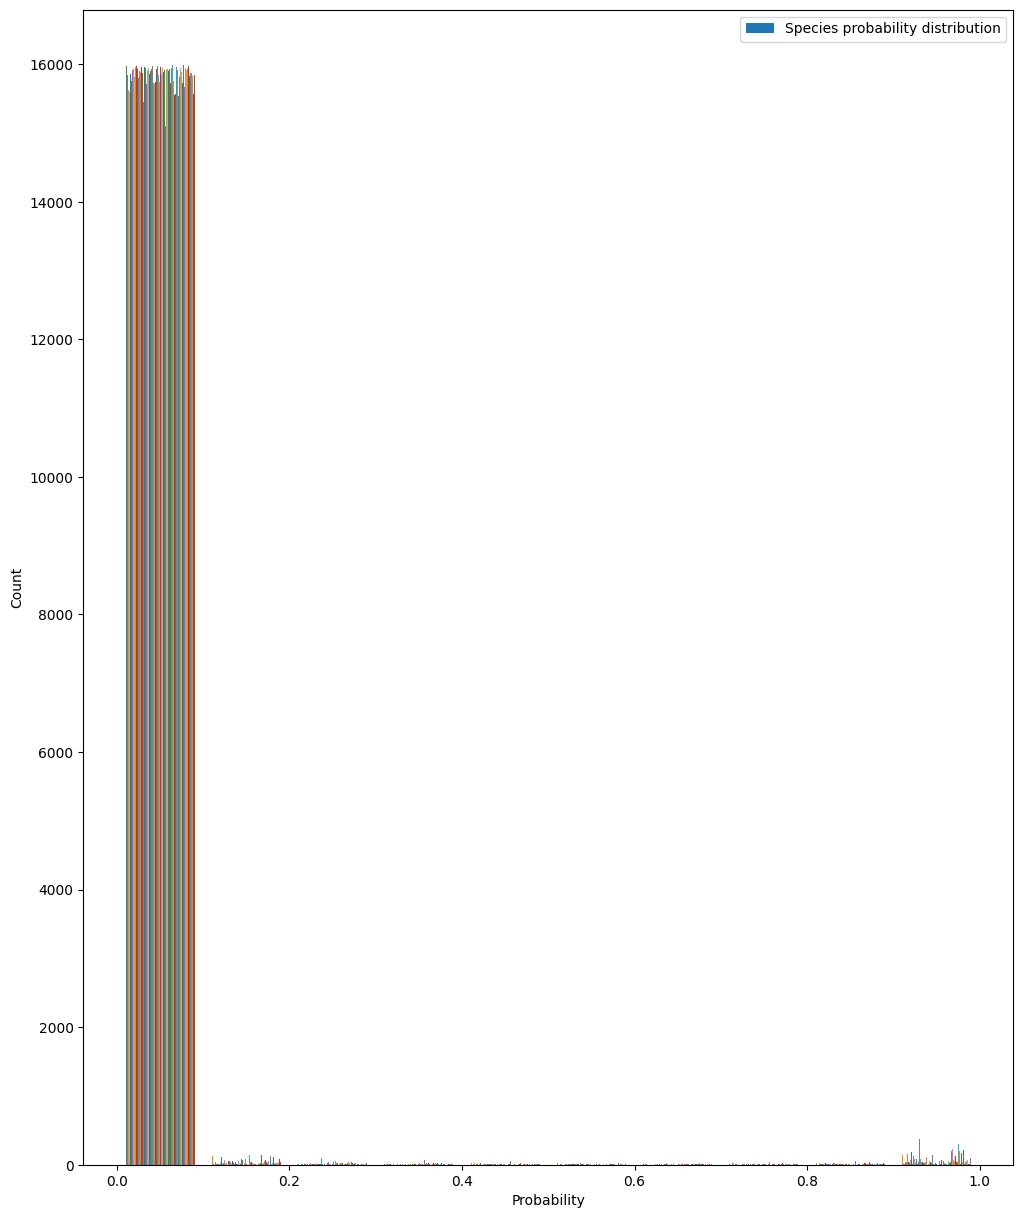

              precision    recall  f1-score   support

     amakin1       0.85      0.64      0.73        55
      amekes       0.69      0.94      0.80       251
     ampkin1       1.00      0.59      0.74        17
      anhing       0.94      0.53      0.68        60
      babwar       0.88      0.83      0.86       103
     bafibi1       1.00      0.71      0.83        17
      banana       0.97      0.90      0.93       359
      baymac       0.84      0.86      0.85        94
      bbwduc       0.87      0.92      0.89       246
     bicwre1       0.93      0.91      0.92        57
      bkcdon       0.94      0.88      0.91       102
     bkmtou1       0.99      0.90      0.94       191
     blbgra1       0.99      0.88      0.93       233
     blbwre1       0.90      0.86      0.88        73
     blcant4       0.87      0.83      0.85        64
     blchaw1       0.64      0.82      0.72        33
     blcjay1       0.96      0.80      0.88        61
     blctit1       1.00    

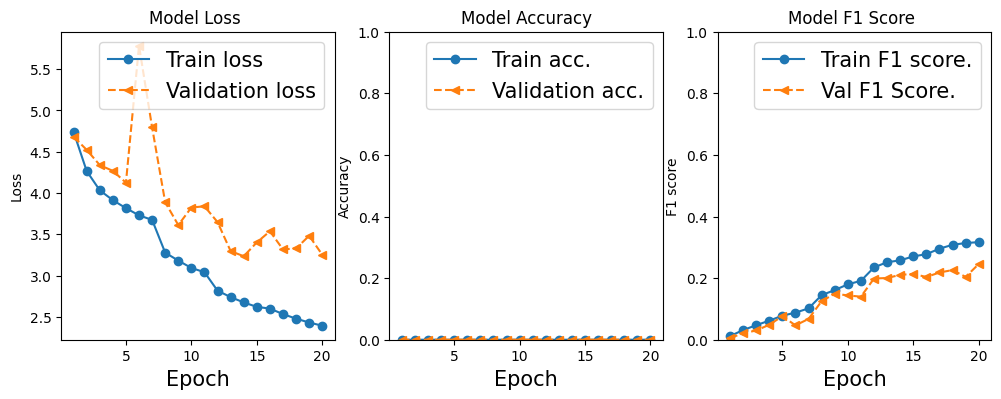

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


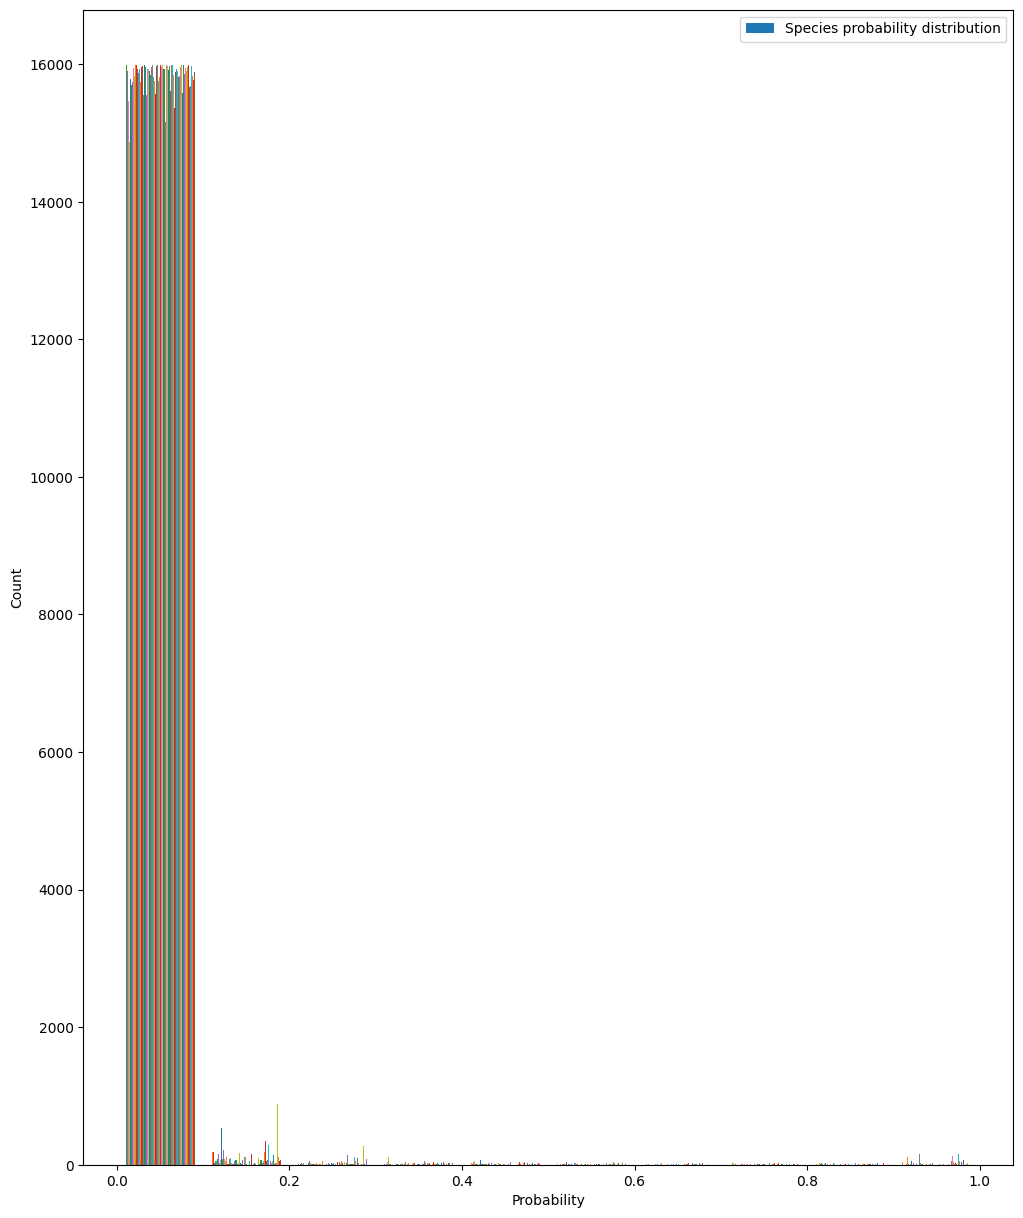

              precision    recall  f1-score   support

     amakin1       0.50      0.20      0.29        55
      amekes       0.50      0.65      0.56       251
     ampkin1       1.00      0.06      0.11        17
      anhing       0.20      0.42      0.27        60
      babwar       0.73      0.23      0.35       103
     bafibi1       0.42      0.47      0.44        17
      banana       0.66      0.74      0.69       359
      baymac       0.64      0.45      0.53        94
      bbwduc       0.22      0.80      0.34       246
     bicwre1       0.54      0.58      0.56        57
      bkcdon       0.48      0.52      0.50       102
     bkmtou1       0.90      0.81      0.85       191
     blbgra1       0.87      0.77      0.82       233
     blbwre1       0.96      0.36      0.52        73
     blcant4       0.26      0.45      0.33        64
     blchaw1       0.25      0.03      0.05        33
     blcjay1       0.80      0.20      0.32        61
     blctit1       0.00    

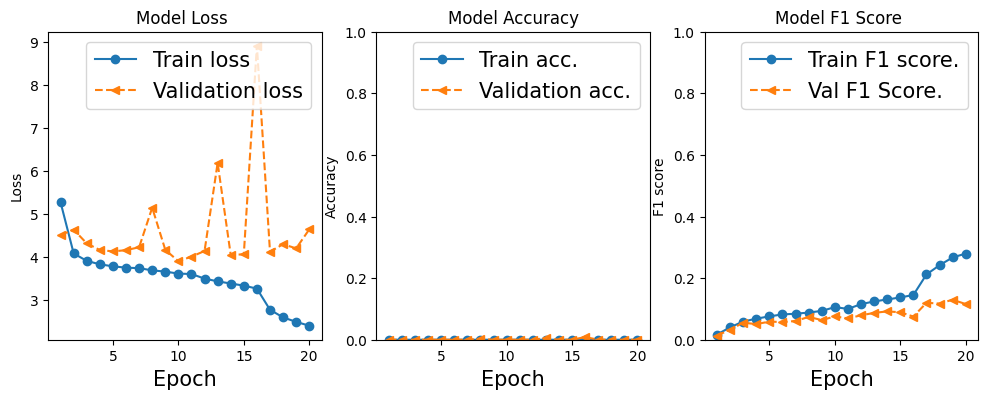

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


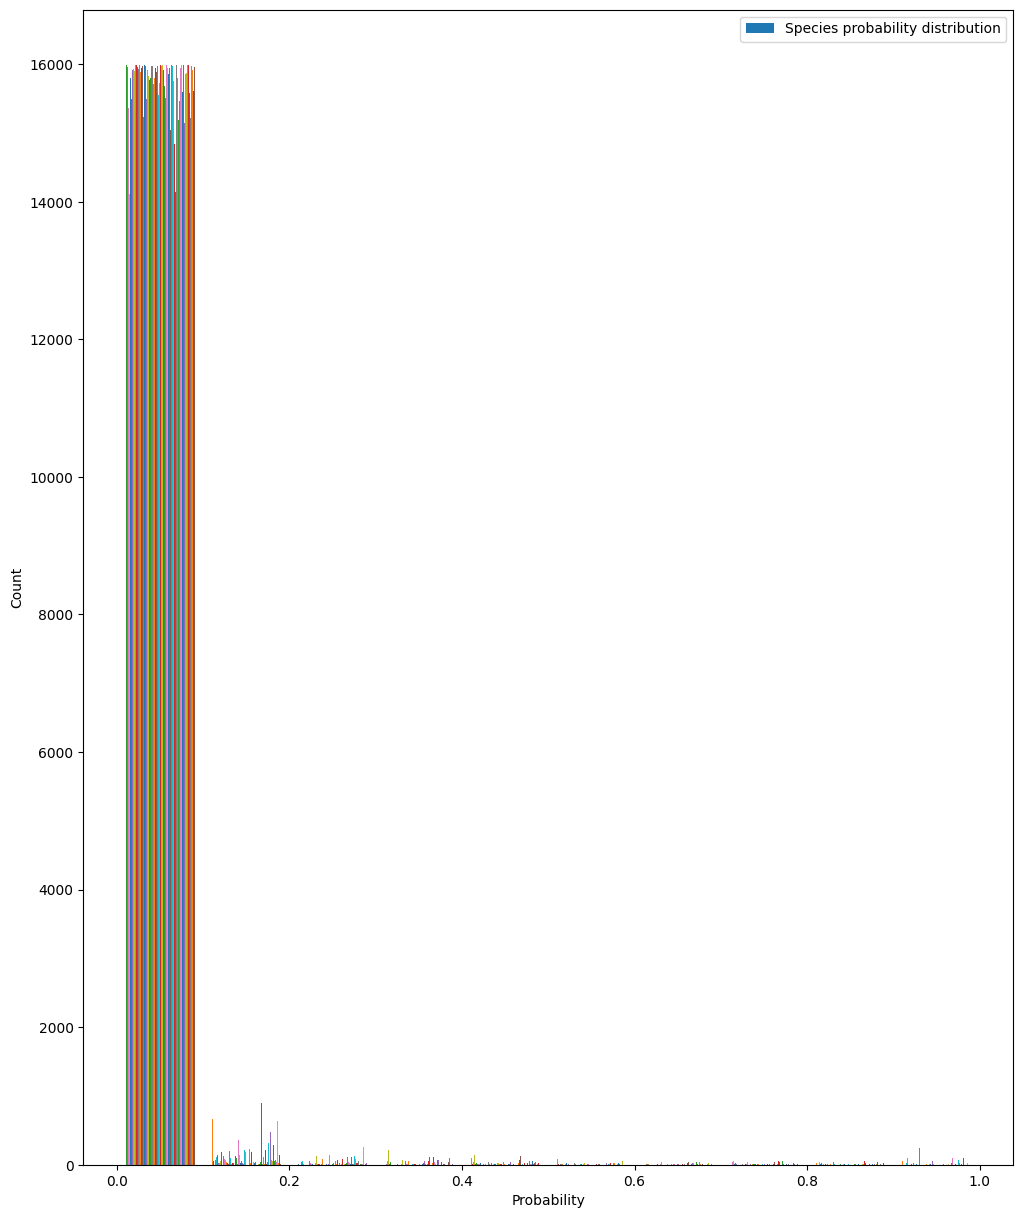

              precision    recall  f1-score   support

     amakin1       0.08      0.02      0.03        55
      amekes       0.20      0.63      0.31       251
     ampkin1       1.00      0.12      0.21        17
      anhing       0.19      0.12      0.15        60
      babwar       1.00      0.06      0.11       103
     bafibi1       0.00      0.00      0.00        17
      banana       0.61      0.66      0.63       359
      baymac       0.44      0.44      0.44        94
      bbwduc       0.16      0.63      0.26       246
     bicwre1       0.26      0.60      0.37        57
      bkcdon       0.50      0.43      0.46       102
     bkmtou1       0.97      0.73      0.83       191
     blbgra1       0.59      0.76      0.67       233
     blbwre1       1.00      0.03      0.05        73
     blcant4       0.67      0.38      0.48        64
     blchaw1       0.00      0.00      0.00        33
     blcjay1       0.67      0.33      0.44        61
     blctit1       0.00    

In [250]:
optimizer_list = ['Adam', 'RMSprop', "SGD"]
learn_rate_list = [0.1, 0.01, 0.001]
kernel_list = [2,4,8]
#maxpool_list = [2,4]
batch_size_list = [16, 32, 64]
stride_list = [(1,1), (2,2)]



#kernel
for item in kernel_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, kernel=item)
"""
#Maxpool
for item in maxpool_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, maxpool=item)
"""

#Batch Size
for item in batch_size_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, batch=item)
#Optimizer
for item in optimizer_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, optimizer=item)

#Learn Rate
for item in learn_rate_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, learn_rate=item)

#Stride
for item in stride_list:
      evaluate_tuning_model_1(X_aves_cnn, y_aves_cnn, stride=item)




### Summary of HyperParameter Tuning Results

|Model|conv blocks|dense layers|conv_dropout|dense_dropouut|batch|epochs|learning_rate|optimizer|kernel|stride|macro_f1|accuracy avg|yectyr1 recall|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(2,2)|(2,2)|0.66|0.63|0.50|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)|0.84|0.84|0.73|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(8,8)|(2,2)|0.91|0.91|0.80|
|Model 3|3|(128,128)|0.2|0.3|16|20|0.01|Adam|(4,4)|(2,2)|0.90|0.90|0.87|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)|0.96|0.96|0.95|
|Model 3|3|(128,128)|0.2|0.3|64|20|0.01|Adam|(4,4)|(2,2)|0.91|0.90|0.72|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)|0.95|0.94|0.92|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|RMSprop|(4,4)|(2,2)|0.98|0.98|0.95|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|SGD|(4,4)|(2,2)|0.88|0.89|0.86|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.1|Adam|(4,4)|(2,2)|0.25|0.36|0.00|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(4,4)|(2,2)|0.91|0.91|0.92|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.001|Adam|(4,4)|(2,2)|0.92|0.92|0.92|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(1,1)|(2,2)|0.72|0.73|0.74|
|Model 3|3|(128,128)|0.2|0.3|32|20|0.01|Adam|(1,1)|(2,2)|0.95|0.94|0.93|

From the Hyperparameter tuning, we observe that following parameters give higher f1 score though there is overfitting.
- kernel = (4,4)
- batch = 32
- optimizer = RMSprop
- learning rate = 0.01
- stride = (2,2)
We will use these values for the evaluation model

# Evaluating Aves Species Model

In [251]:
def build_evaluation_model_1(img_size, output_size):
  """ Model will be based on model 3 with configurable hyper parameters to aid tuninig
  """
  #set defaults
  maxpool=(2,2)
  learn_rate=0.01
  kernel=(4,4)
  optimizer='Adam'
  stride=(2,2)

  dropout = 0.3
  dropout_dense = 0.4

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D(maxpool)(normal_1)
 # dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D(maxpool)(normal_2)
 # dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

  # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(maxpool_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D(maxpool)(normal_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  flat_1 = tf.keras.layers.GlobalAveragePooling2D()(dropout_3)
  dense_1 = tf.keras.layers.Dense(128)(flat_1)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_1)
  dense_2 = tf.keras.layers.Dense(128)(dropout_4)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_5)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')


  # compile model
  if optimizer == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  elif optimizer == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=learn_rate)
  model.compile(
      optimizer=opt,
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])

  #print(model.summary())
  return model

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.0010 - f1_score: 0.0094 - loss: 7.0453 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0061 - val_loss: 4.7916
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0220 - loss: 4.3719 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0176 - val_loss: 4.3951
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0412 - loss: 4.0222 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0309 - val_loss: 4.5463
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0614 - loss: 3.8734 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0576 - val_loss: 3.9187
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0657 - loss: 3.7624 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0672 - val_loss: 3.9153
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0735 - loss: 3.6930 - v

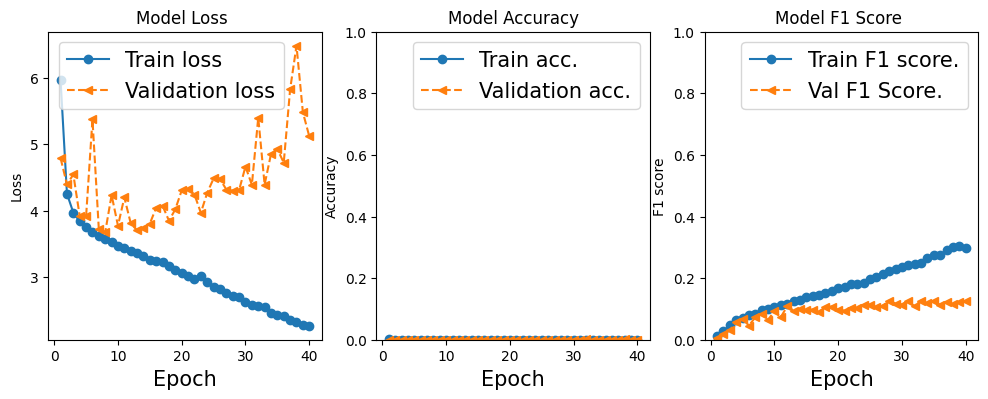

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  15993
predicted_labels length :  15993
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


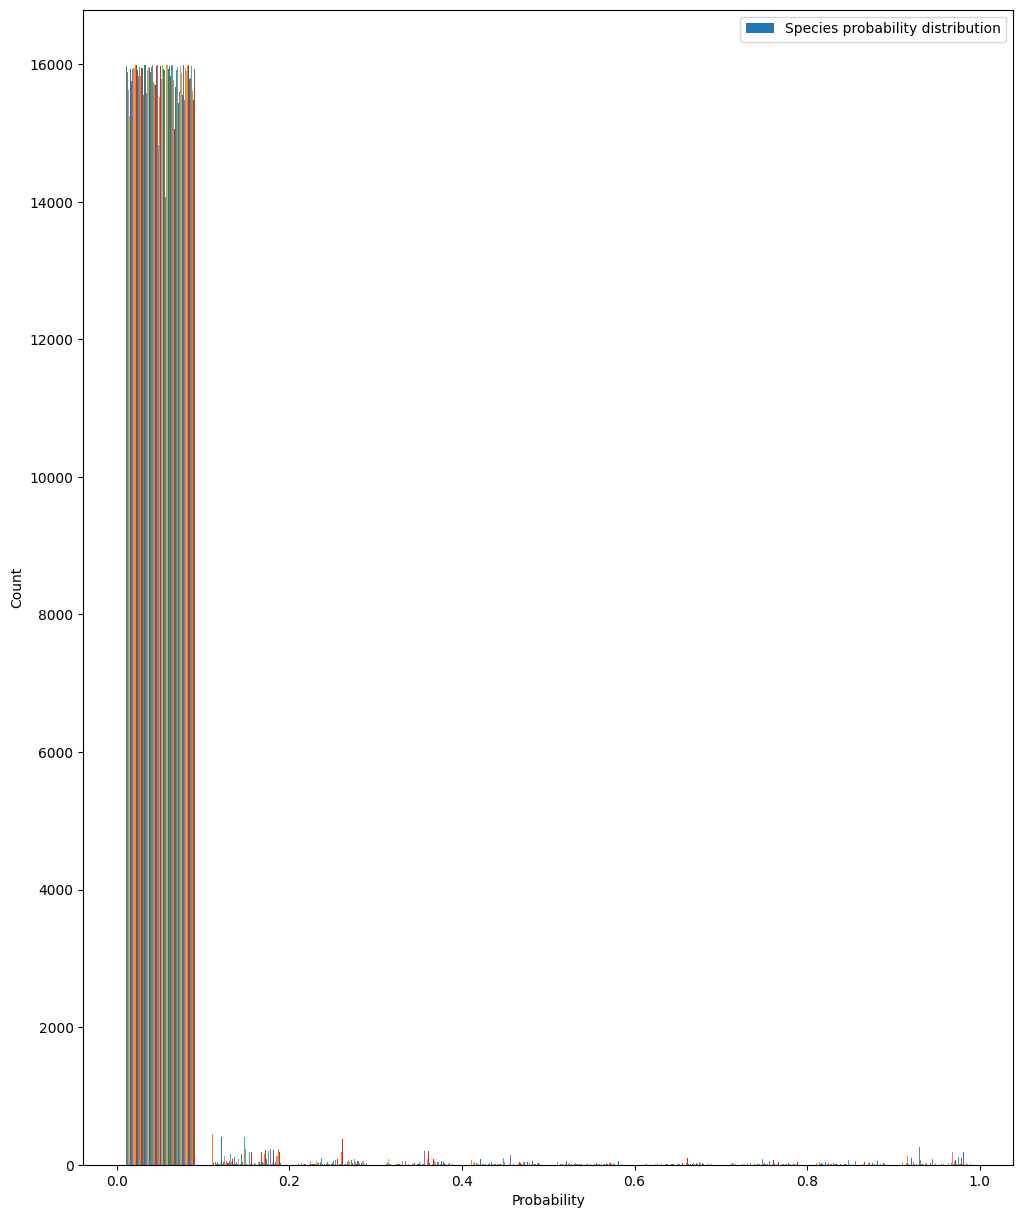

              precision    recall  f1-score   support

     amakin1       0.80      0.15      0.25        55
      amekes       0.36      0.80      0.50       251
     ampkin1       0.56      0.29      0.38        17
      anhing       0.55      0.18      0.28        60
      babwar       0.71      0.35      0.47       103
     bafibi1       1.00      0.18      0.30        17
      banana       0.90      0.66      0.76       359
      baymac       0.66      0.40      0.50        94
      bbwduc       0.51      0.74      0.60       246
     bicwre1       0.83      0.60      0.69        57
      bkcdon       0.93      0.39      0.55       102
     bkmtou1       0.96      0.84      0.90       191
     blbgra1       0.92      0.68      0.78       233
     blbwre1       0.95      0.29      0.44        73
     blcant4       0.90      0.55      0.68        64
     blchaw1       0.50      0.09      0.15        33
     blcjay1       0.94      0.28      0.43        61
     blctit1       0.00    

In [252]:
species_model_aves = build_evaluation_model_1(X_aves_cnn.shape[1],
                                              y_aves_cnn.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_cnn,
    y_aves_cnn,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    epochs=40)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_cnn,
                      y_aves_cnn)

In [253]:
result_eval = species_model_aves.evaluate(X_aves_test,
                          y_aves_test,
                                        return_dict=True)

print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 4.1502e-05 - f1_score: 0.1194 - loss: 4.9588
evaluation results =  {'accuracy': 7.0598725869786e-05, 'f1_score': 0.12778456509113312, 'loss': 5.053608417510986}

Test Acc. 0.0071%

Test F1-score MACRO. 12.7785%


We need to increase generalization ( dropout)

In [254]:
def build_evaluation_model_2(img_size, output_size):
  """ Model will be based on model 3 with  hyper parameters from tuninig
  """
  #set defaults
  maxpool=(2,2)
  learn_rate=0.01
  kernel=(4,4)
  optimizer='Adam'
  stride=(2,2)

  dropout = 0.3
  dropout_dense = 0.5

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D(maxpool)(normal_1)
 # dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D(maxpool)(normal_2)
  dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

  # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=kernel,
      strides=stride,
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(dropout_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D(maxpool)(normal_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  flat_1 = tf.keras.layers.GlobalAveragePooling2D()(dropout_3)
  dense_1 = tf.keras.layers.Dense(128)(flat_1)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_1)
  dense_2 = tf.keras.layers.Dense(128)(dropout_4)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout_dense)(dense_2)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_5)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')


  # compile model
  if optimizer == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  elif optimizer == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=learn_rate)
  model.compile(
      optimizer=opt,
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])

  #print(model.summary())
  return model

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.0000e+00 - f1_score: 0.0092 - loss: 6.2500 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0187 - val_loss: 4.4325
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0256 - loss: 4.2825 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0404 - val_loss: 4.0380
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - f1_score: 0.0347 - loss: 4.1719 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0583 - val_loss: 3.8981
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0409 - loss: 4.1102 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0534 - val_loss: 3.8843
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.0436 - loss: 4.0984 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0657 - val_loss: 3.8197
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - f1_score: 0.0481 - loss: 

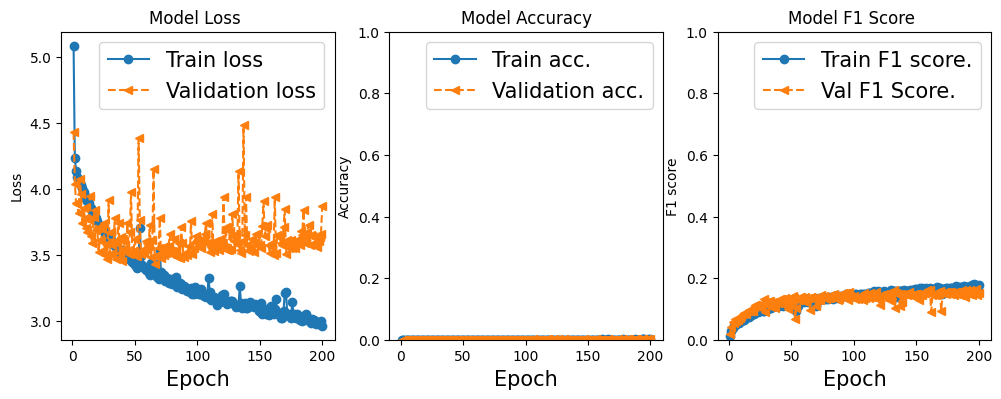

final train acc: 0.001
final val acc:   0.001

Unable to calculate percent diff as Train accuracy is zero
test_label length :  31986
predicted_labels length :  31986
confusion matrix shape= (146, 146)
number of labels > 10. number of labels =  146


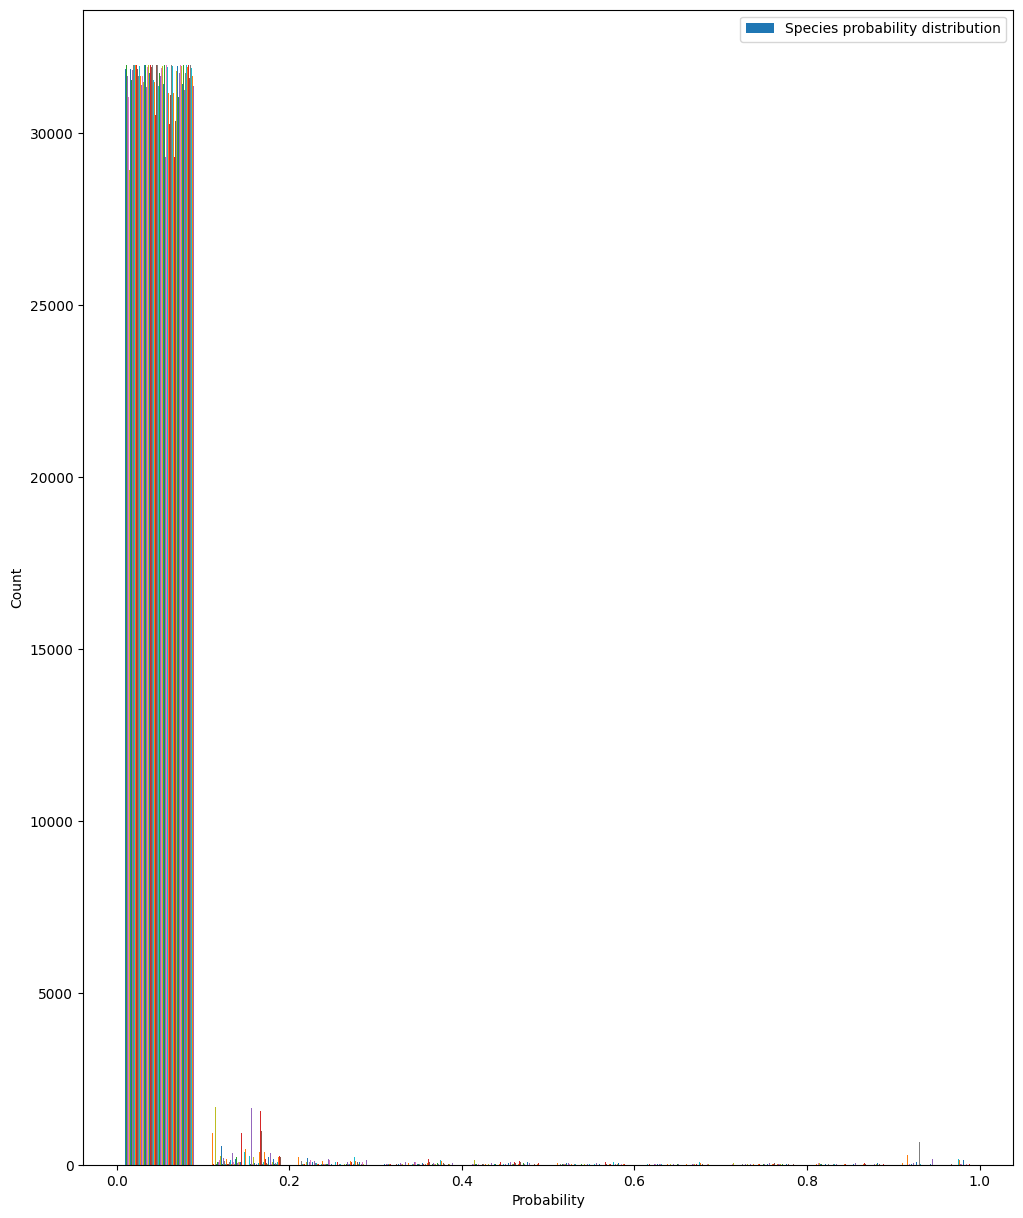

              precision    recall  f1-score   support

     amakin1       0.56      0.28      0.38       110
      amekes       0.41      0.77      0.54       502
     ampkin1       0.00      0.00      0.00        34
      anhing       0.67      0.02      0.03       120
      babwar       0.47      0.04      0.08       206
     bafibi1       1.00      0.12      0.21        34
      banana       0.86      0.89      0.88       718
      baymac       0.31      0.20      0.24       188
      bbwduc       0.19      0.83      0.31       492
     bicwre1       0.89      0.49      0.63       114
      bkcdon       0.99      0.38      0.55       204
     bkmtou1       0.90      0.87      0.89       382
     blbgra1       0.95      0.76      0.85       466
     blbwre1       0.78      0.56      0.65       146
     blcant4       0.63      0.42      0.50       128
     blchaw1       1.00      0.03      0.06        66
     blcjay1       0.63      0.62      0.63       122
     blctit1       0.00    

In [255]:
species_model_aves = build_evaluation_model_2(X_aves_cnn_augm.shape[1],
                                              y_aves_cnn_augm.shape[1])

# train model on (X_train, y_train) data
history = species_model_aves.fit(
    X_aves_cnn_augm,
    y_aves_cnn_augm,
    validation_data=(X_aves_val,y_aves_val),
    batch_size=64,
    epochs=200)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(species_model_aves,
                      X_aves_cnn_augm,
                      y_aves_cnn_augm)

In [256]:
result_eval = species_model_aves.evaluate(X_aves_test,
                          y_aves_test,
                                        return_dict=True)

print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0013 - f1_score: 0.1448 - loss: 3.7837
evaluation results =  {'accuracy': 0.0012484823819249868, 'f1_score': 0.15299759805202484, 'loss': 3.8072335720062256}

Test Acc. 0.1248%

Test F1-score MACRO. 15.2998%
